# Load Modules


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
import sklearn
import seaborn as sns

# Datenaufbereitung

## Libraries & Settings

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [3]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import data_files, load_bin, store_bin, load_csv, write_xlsx, load_xlsx
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    unfactorize,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

## Load data

In [4]:
%%time
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-09-05 14:12:36 [INFO] Reading from file C:\Users\stc\data\bd_data.feather
2019-09-05 14:12:36 [INFO] Finished loading binary file in 0.18s (0.8s CPU)


Wall time: 1.52 s


In [5]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,category,0/675378,32244
Endkunde,category,0/675378,30312
EK_Abc,category,1154/674224,8
EK_Boni,category,76/675302,3
EK_Plz,category,164/675214,2975
EK_Ort,category,164/675214,3023
EK_Land,category,164/675214,46
EK_HB_Apg_Kurzz,category,27734/647644,89
EK_Aktiv,category,0/675378,2
Agentur,category,322648/352730,3967


In [6]:
def last_notna(s):
    try:
        return s.loc[s.last_valid_index()]
    except KeyError:
        return np.NaN


def collect(s, sep=","):
    return sep.join(map(str, s[s.notna()].unique()))


# this takes around 90 seconds
with time_log("preparing EK_INFO"):
    ek_info = (
        bd.sort_values(["Endkunde_NR", "Kampagne_Erfassungsdatum"])
        .astype({"Endkunde_NR": "int64", "Kamp_Erfass_Jahr": "int16"})
        .groupby("Endkunde_NR")
        .agg(
            {
                "Endkunde": last_notna,
                "EK_Aktiv": last_notna,
                "EK_Land": last_notna,
                "EK_Plz": last_notna,
                "EK_Ort": last_notna,
                "Agentur": last_notna,
                "Endkunde_Branchengruppe": last_notna,
                "Endkunde_Branchengruppe_ID": last_notna,
                "Auftrag_Branchengruppe_ID": [collect, "nunique"],
                "Kamp_Erfass_Jahr": ["min", "max"],
                "Kampagne_Erfassungsdatum": ["min","max"] # max is kind of useless though, since it depends on the respective view date.
            }
        )
    )

ek_info.set_axis(
    labels="""Endkunde EK_Aktiv EK_Land EK_Plz EK_Ort Agentur EK_BG EK_BG_ID Auftrag_BG_ID Auftrag_BG_Anz 
              Kamp_Erfass_Jahr_min Kamp_Erfass_Jahr_max Kampagne_Erfass_Datum_min Kampagne_Erfass_Datum_max""".split(),
    axis="columns",
    inplace=True,
)

ek_info = ek_info.reset_index()

2019-09-05 14:14:03 [INFO] Finished preparing EK_INFO in 81.81s (82.86s CPU)


In [7]:
ek_info.head(3)

,Endkunde_NR,Endkunde,EK_Aktiv,EK_Land,EK_Plz,EK_Ort,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Kamp_Erfass_Jahr_min,Kamp_Erfass_Jahr_max,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max
0,100034,Maurer + Salzmann AG,1,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2009,2018,2009-02-09,2018-10-31
1,100039,Bank BSU Genossenschaft,1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2009,2019,2009-01-01,2019-09-01
2,100061,Mundwiler Juwelen AG,1,SCHWEIZ,8400,Winterthur,NaN,WG - Persönlicher Bedarf,555,555,1,2009,2009,2009-09-16,2009-09-16


## Aggregate bookings per customer, year, and KW_2 / KW_4 period

In [8]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [9]:
#bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_2w = aggregate_bookings(bd, 'KW_2')

#bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')
#bd_aggr_4w = aggregate_bookings(bd, 'KW_4')

2019-09-05 14:14:13 [INFO] Period: KW_2
2019-09-05 14:14:13 [INFO] Calculate Reservation...
2019-09-05 14:14:13 [INFO] Calculate Aushang...
2019-09-05 14:14:13 [INFO] Merge Results...


In [10]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus
0,103092,2007,45,5310.0,0.0
1,114140,2007,23,50000.0,0.0
2,116266,2007,23,5700.0,0.0
3,142915,2007,13,50000.0,0.0
4,165220,2007,23,587.0,0.0
5,177225,2007,45,2365.0,0.0
6,469638,2007,51,1071.0,0.0
7,494570,2007,45,5250.0,0.0
8,494878,2007,47,5900.0,0.0
9,100098,2008,39,16755.0,0.0


## Sum of Netto_Sum_Res (Reservations) and Netto_Sum_Aus (Aushang) for each KW_2 grouped by Endkunde_NR * Year

In [12]:
bd_netto_2w_data = bd_aggr_2w.pivot_table(
    #index=["Endkunde_NR", "Jahr"],
    index=["Endkunde_NR"],
    #columns="KW_2",
    columns = ["Jahr","KW_2"],
    values=["Netto_Sum_Res","Netto_Sum_Aus"] , # Cash amount of Resevation placed per in weeks of YYYYKW and YYYY(KW+1)
    aggfunc="sum",
    fill_value=0, # There's a difference between 0 and NaN. Consider 0 only when the customer has had a real booking or reservation prior.
)

# drop years with no reservations
bd_netto_2w_data = bd_netto_2w_data.loc[bd_netto_2w_data.sum(axis="columns") > 0]

In [13]:
bd_netto_2w_data.head(10)

Netto_Sum_Aus                                                    \
Jahr                 2007             2008                                    
KW_2                   13 23 45 47 51   1  3  5  7  9  11 13 15 17 19 21 23   
Endkunde_NR                                                                   
100034                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100039                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100061                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100064                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100066                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100083                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100092                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100095                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100097                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   
100098                  0  0  0  0  0    0  0  0  0  0  0  0  0  0  0  0  0   

                                                                              \
Jahr                                                    2009                   
KW_2        25 27 29 31 33 35 37 39 41 43 45 47 49 51     1  3  5  7      9    
Endkunde_NR                                                                    
100034       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100039       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100061       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100064       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100066       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100083       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100092       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100095       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0  22519   
100097       0  0  0  0  0  0  0  0  0  0  0  0  0  0      0  0  0  0      0   
100098       0  0  0  0  0  0  0  0  0  0  0  0  0  0  16755  0  0  0      0   

                                                                            \
Jahr                                                                         
KW_2        11     13    15 17 19 21     23 25    27 29 31     33 35 37 39   
Endkunde_NR                                                                  
100034       0  23234     0  0  0  0   3933  0     0  0  0      0  0  0  0   
100039       0   2700  6570  0  0  0      0  0     0  0  0      0  0  0  0   
100061       0      0     0  0  0  0      0  0     0  0  0      0  0  0  0   
100064       0      0     0  0  0  0      0  0  2000  0  0      0  0  0  0   
100066       0      0     0  0  0  0      0  0     0  0  0      0  0  0  0   
100083       0      0     0  0  0  0      0  0     0  0  0      0  0  0  0   
100092       0      0     0  0  0  0  43294  0     0  0  0      0  0  0  0   
100095       0      0     0  0  0  0      0  0     0  0  0  30002  0  0  0   
100097       0      0     0  0  0  0      0  0     0  0  0      0  0  0  0   
100098       0      0     0  0  0  0      0  0     0  0  0      0  0  0  0   

                                                                              \
Jahr                                      2010                                 
KW_2           41    43 45     47 49 51     1  3  5       7     9  11     13   
Endkunde_NR                                                                    
100034          0  9000  0  30286  0  0      0  0  0       0     0  0  22495   
100039          0     0  0      0  0  0      0  0  0       0     0  0   2700   
100061       4105     0  0      0  0  0      0  0  0       0     0  0      0   
100064          0     0  0      0  0  0      0  0  0       0     0  0      0   
100066          0     0  0      0  0  0      0  0  

In [14]:
#%% flatten booking dataset
bd_netto_2w_data_flattened = pd.DataFrame(bd_netto_2w_data.to_records())

#%% Clean up column names
raw_col_names_bd = list(bd_netto_2w_data_flattened.columns)[1:bd_netto_2w_data_flattened.shape[1]]
splitted_col_names = [x.lstrip("(").rstrip(")").split(", ") for x in list(bd_netto_2w_data_flattened.columns)[1:bd_netto_2w_data_flattened.shape[1]]]
col_names_flattened = [bd_netto_2w_data_flattened.columns[0]] + [(content_name.replace("'",""), int(x)*100+int(y)) for [content_name,x,y] in splitted_col_names]

#%% Set cleaned up column names
bd_netto_2w_data_flattened.columns = col_names_flattened

In [15]:
bd_netto_2w_data_flattened.head(5)
display(bd_netto_2w_data_flattened.columns)

Index([            'Endkunde_NR', ('Netto_Sum_Aus', 200713),
       ('Netto_Sum_Aus', 200723), ('Netto_Sum_Aus', 200745),
       ('Netto_Sum_Aus', 200747), ('Netto_Sum_Aus', 200751),
       ('Netto_Sum_Aus', 200801), ('Netto_Sum_Aus', 200803),
       ('Netto_Sum_Aus', 200805), ('Netto_Sum_Aus', 200807),
       ...
       ('Netto_Sum_Res', 202019), ('Netto_Sum_Res', 202023),
       ('Netto_Sum_Res', 202027), ('Netto_Sum_Res', 202029),
       ('Netto_Sum_Res', 202033), ('Netto_Sum_Res', 202037),
       ('Netto_Sum_Res', 202039), ('Netto_Sum_Res', 202041),
       ('Netto_Sum_Res', 202043), ('Netto_Sum_Res', 202109)],
      dtype='object', length=671)

In [16]:
#desc_col(bd_res_netto_2w_data_flattened)
#desc_col(ek_info)

In [17]:
# New bigger data set with booking data added:
ek_info_all = pd.merge(ek_info, bd_netto_2w_data_flattened, on="Endkunde_NR", how='left')

In [19]:
desc_col(ek_info_all)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/32244,32244
Endkunde,object,0/32244,30312
EK_Aktiv,int64,0/32244,2
EK_Land,object,48/32196,46
EK_Plz,object,48/32196,2975
EK_Ort,object,48/32196,3023
Agentur,object,21035/11209,3235
EK_BG,object,1808/30436,83
EK_BG_ID,object,1808/30436,83
Auftrag_BG_ID,object,0/32244,1970


In [4]:
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##
## ## ## ## ## ## ## ## ## ## ## ##

# Import Data: tds == TDS == gv_FILE_OUT_TDS

In [5]:
TDS = pd.read_csv("C:/Users/stc/Documents/notebooks/Verkaufsprognose Modeling/TDS.csv", low_memory=False, sep=';')

In [120]:
display(TDS.describe())
print(TDS.shape)

,ENDKUNDE_NR,AJ,AJ_01,AJ_03,AJ_05,AJ_07,AJ_09,AJ_11,AJ_13,AJ_15,AJ_17,AJ_19,AJ_21,AJ_23,AJ_25,AJ_27,AJ_29,AJ_31,AJ_33,AJ_35,AJ_37,AJ_39,AJ_41,AJ_43,AJ_45,AJ_47,AJ_49,AJ_51,AJNet,AJ_NETKAT_01,AJ_NETKAT_02,AJ_NETKAT_03,AJ_NETKAT_04,AJ_NETKAT_05,AJ_NETKAT_06,AJ_NETKAT_07,AJ_NETKAT_08,AJ_NETKAT_09,AJ_NETKAT_10,VJ_01,VJ_03,VJ_05,VJ_07,VJ_09,VJ_11,VJ_13,VJ_15,VJ_17,VJ_19,VJ_21,VJ_23,VJ_25,VJ_27,VJ_29,VJ_31,VJ_33,VJ_35,VJ_37,VJ_39,VJ_41,VJ_43,VJ_45,VJ_47,VJ_49,VJ_51,VJNet,VJ_NETKAT_01,VJ_NETKAT_02,VJ_NETKAT_03,VJ_NETKAT_04,VJ_NETKAT_05,VJ_NETKAT_06,VJ_NETKAT_07,VJ_NETKAT_08,VJ_NETKAT_09,VJ_NETKAT_10,VVJ_01,VVJ_03,VVJ_05,VVJ_07,VVJ_09,VVJ_11,VVJ_13,VVJ_15,VVJ_17,VVJ_19,VVJ_21,VVJ_23,VVJ_25,VVJ_27,VVJ_29,VVJ_31,VVJ_33,VVJ_35,VVJ_37,VVJ_39,VVJ_41,VVJ_43,VVJ_45,VVJ_47,VVJ_49,VVJ_51,VVJNet,VVJ_NETKAT_01,VVJ_NETKAT_02,VVJ_NETKAT_03,VVJ_NETKAT_04,VVJ_NETKAT_05,VVJ_NETKAT_06,VVJ_NETKAT_07,VVJ_NETKAT_08,VVJ_NETKAT_09,VVJ_NETKAT_10,VVVJ_01,VVVJ_03,VVVJ_05,VVVJ_07,VVVJ_09,VVVJ_11,VVVJ_13,VVVJ_15,VVVJ_17,VVVJ_19,VVVJ_21,VVVJ_23,VVVJ_25,VVVJ_27,VVVJ_29,VVVJ_31,VVVJ_33,VVVJ_35,VVVJ_37,VVVJ_39,VVVJ_41,VVVJ_43,VVVJ_45,VVVJ_47,VVVJ_49,VVVJ_51,VVVJNet,VVVJ_NETKAT_01,VVVJ_NETKAT_02,VVVJ_NETKAT_03,VVVJ_NETKAT_04,VVVJ_NETKAT_05,VVVJ_NETKAT_06,VVVJ_NETKAT_07,VVVJ_NETKAT_08,VVVJ_NETKAT_09,VVVJ_NETKAT_10,B105,B110,B115,B116,B120,B125,B130,B135,B140,B145,B150,B155,B160,B165,B170,B185,B195,B225,B230,B240,B241,B290,B295,B325,B330,B332,B334,B339,B349,B350,B351,B352,B353,B354,B356,B357,B366,B367,B371,B390,B400,B401,B405,B410,B420,B425,B435,B436,B445,B446,B447,B448,B455,B460,B464,B465,B466,B468,B469,B470,B475,B503,B504,B508,B509,B535,B555,B556,B575,B610,B695,B705,B720,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990,AJ_KONTAKT_L1_KW01,AJ_KONTAKT_L1_KW03,AJ_KONTAKT_L1_KW05,AJ_KONTAKT_L1_KW07,AJ_KONTAKT_L1_KW09,AJ_KONTAKT_L1_KW11,AJ_KONTAKT_L1_KW13,AJ_KONTAKT_L1_KW15,AJ_KONTAKT_L1_KW17,AJ_KONTAKT_L1_KW19,AJ_KONTAKT_L1_KW21,AJ_KONTAKT_L1_KW23,AJ_KONTAKT_L1_KW25,AJ_KONTAKT_L1_KW27,AJ_KONTAKT_L1_KW29,AJ_KONTAKT_L1_KW31,AJ_KONTAKT_L1_KW33,AJ_KONTAKT_L1_KW35,AJ_KONTAKT_L1_KW37,AJ_KONTAKT_L1_KW39,AJ_KONTAKT_L1_KW41,AJ_KONTAKT_L1_KW43,AJ_KONTAKT_L1_KW45,AJ_KONTAKT_L1_KW47,AJ_KONTAKT_L1_KW49,AJ_KONTAKT_L1_KW51,AJ_KONTAKT_L2_KW01,AJ_KONTAKT_L2_KW03,AJ_KONTAKT_L2_KW05,AJ_KONTAKT_L2_KW07,AJ_KONTAKT_L2_KW09,AJ_KONTAKT_L2_KW11,AJ_KONTAKT_L2_KW13,AJ_KONTAKT_L2_KW15,AJ_KONTAKT_L2_KW17,AJ_KONTAKT_L2_KW19,AJ_KONTAKT_L2_KW21,AJ_KONTAKT_L2_KW23,AJ_KONTAKT_L2_KW25,AJ_KONTAKT_L2_KW27,AJ_KONTAKT_L2_KW29,AJ_KONTAKT_L2_KW31,AJ_KONTAKT_L2_KW33,AJ_KONTAKT_L2_KW35,AJ_KONTAKT_L2_KW37,AJ_KONTAKT_L2_KW39,AJ_KONTAKT_L2_KW41,AJ_KONTAKT_L2_KW43,AJ_KONTAKT_L2_KW45,AJ_KONTAKT_L2_KW47,AJ_KONTAKT_L2_KW49,AJ_KONTAKT_L2_KW51,VJ_KONTAKT_L1_KW01,VJ_KONTAKT_L1_KW03,VJ_KONTAKT_L1_KW05,VJ_KONTAKT_L1_KW07,VJ_KONTAKT_L1_KW09,VJ_KONTAKT_L1_KW11,VJ_KONTAKT_L1_KW13,VJ_KONTAKT_L1_KW15,VJ_KONTAKT_L1_KW17,VJ_KONTAKT_L1_KW19,VJ_KONTAKT_L1_KW21,VJ_KONTAKT_L1_KW23,VJ_KONTAKT_L1_KW25,VJ_KONTAKT_L1_KW27,VJ_KONTAKT_L1_KW29,VJ_KONTAKT_L1_KW31,VJ_KONTAKT_L1_KW33,VJ_KONTAKT_L1_KW35,VJ_KONTAKT_L1_KW37,VJ_KONTAKT_L1_KW39,VJ_KONTAKT_L1_KW41,VJ_KONTAKT_L1_KW43,VJ_KONTAKT_L1_KW45,VJ_KONTAKT_L1_KW47,VJ_KONTAKT_L1_KW49,VJ_KONTAKT_L1_KW51,VJ_KONTAKT_L2_KW01,VJ_KONTAKT_L2_KW03,VJ_KONTAKT_L2_KW05,VJ_KONTAKT_L2_KW07,VJ_KONTAKT_L2_KW09,VJ_KONTAKT_L2_KW11,VJ_KONTAKT_L2_KW13,VJ_KONTAKT_L2_KW15,VJ_KONTAKT_L2_KW17,VJ_KONTAKT_L2_KW19,VJ_KONTAKT_L2_KW21,VJ_KONTAKT_L2_KW23,VJ_KONTAKT_L2_KW25,VJ_KONTAKT_L2_KW27,VJ_KONTAKT_L2_KW29,VJ_KONTAKT_L2_KW31,VJ_KONTAKT_L2_KW33,VJ_KONTAKT_L2_KW35,VJ_KONTAKT_L2_KW37,VJ_KONTAKT_L2_KW39,VJ_KONTAKT_L2_KW41,VJ_KONTAKT_L2_KW43,VJ_KONTAKT_L2_KW45,VJ_KONTAKT_L2_KW47,VJ_KONTAKT_L2_KW49,VJ_KONTAKT_L2_KW51,VVJ_KONTAKT_L1_KW01,VVJ_KONTAKT_L1_KW03,VVJ_KONTAKT_L1_KW05,VVJ_KONTAKT_L1_KW07,VVJ_KONTAKT_L1_KW09,VVJ_KONTAKT_L1_KW11,VVJ_KONTAKT_L1_KW13,VVJ_KONTAKT_L1_KW15,VVJ_KONTAKT_L1_KW17,VVJ_KONTAKT_L1_KW19,VVJ_KONTAKT_L1_KW21,VVJ_KONTAKT_L1_KW23,VVJ_KONTAKT_L1_KW25,VVJ_KONTAKT_L1_KW27,VVJ_KONTAKT_L1_KW29,VVJ_KONTAKT_L1

(39215, 441)


In [7]:
TDS.head(5)
#DS.info()

,ENDKUNDE_NR,AJ,AJ_01,AJ_03,AJ_05,AJ_07,AJ_09,AJ_11,AJ_13,AJ_15,...,VVVJ_KONTAKT_L2_KW33,VVVJ_KONTAKT_L2_KW35,VVVJ_KONTAKT_L2_KW37,VVVJ_KONTAKT_L2_KW39,VVVJ_KONTAKT_L2_KW41,VVVJ_KONTAKT_L2_KW43,VVVJ_KONTAKT_L2_KW45,VVVJ_KONTAKT_L2_KW47,VVVJ_KONTAKT_L2_KW49,VVVJ_KONTAKT_L2_KW51
0,100034,2016,0.0,20909.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,100034,2017,0.0,0.0,7897.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100034,2018,0.0,0.0,3963.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,100034,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,100039,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Intermezzo: Whiteboard problems

In [183]:
# Which customers have the most rows in the dataframe?
(TDS.groupby(["ENDKUNDE_NR"]).size().to_frame('COUNT')
                             .reset_index()
                             .sort_values(['COUNT', 'ENDKUNDE_NR'],ascending=[False,False])
                             .head(10))


,ENDKUNDE_NR,COUNT
7847,611096,5
7756,610161,5
7643,608966,5
7444,607026,5
7396,606449,5
7394,606413,5
7393,606399,5
7388,606341,5
7386,606332,5
7385,606320,5


In [190]:
TDS.loc[TDS.ENDKUNDE_NR == 606399, # row selection
        :
        
       ]         # column selection

,ENDKUNDE_NR,AJ,AJ_01,AJ_03,AJ_05,AJ_07,AJ_09,AJ_11,AJ_13,AJ_15,AJ_17,AJ_19,AJ_21,AJ_23,AJ_25,AJ_27,AJ_29,AJ_31,AJ_33,AJ_35,AJ_37,AJ_39,AJ_41,AJ_43,AJ_45,AJ_47,AJ_49,AJ_51,AJNet,AJ_NETKAT_01,AJ_NETKAT_02,AJ_NETKAT_03,AJ_NETKAT_04,AJ_NETKAT_05,AJ_NETKAT_06,AJ_NETKAT_07,AJ_NETKAT_08,AJ_NETKAT_09,AJ_NETKAT_10,VJ_01,VJ_03,VJ_05,VJ_07,VJ_09,VJ_11,VJ_13,VJ_15,VJ_17,VJ_19,VJ_21,VJ_23,VJ_25,VJ_27,VJ_29,VJ_31,VJ_33,VJ_35,VJ_37,VJ_39,VJ_41,VJ_43,VJ_45,VJ_47,VJ_49,VJ_51,VJNet,VJ_NETKAT_01,VJ_NETKAT_02,VJ_NETKAT_03,VJ_NETKAT_04,VJ_NETKAT_05,VJ_NETKAT_06,VJ_NETKAT_07,VJ_NETKAT_08,VJ_NETKAT_09,VJ_NETKAT_10,VVJ_01,VVJ_03,VVJ_05,VVJ_07,VVJ_09,VVJ_11,VVJ_13,VVJ_15,VVJ_17,VVJ_19,VVJ_21,VVJ_23,VVJ_25,VVJ_27,VVJ_29,VVJ_31,VVJ_33,VVJ_35,VVJ_37,VVJ_39,VVJ_41,VVJ_43,VVJ_45,VVJ_47,VVJ_49,VVJ_51,VVJNet,VVJ_NETKAT_01,VVJ_NETKAT_02,VVJ_NETKAT_03,VVJ_NETKAT_04,VVJ_NETKAT_05,VVJ_NETKAT_06,VVJ_NETKAT_07,VVJ_NETKAT_08,VVJ_NETKAT_09,VVJ_NETKAT_10,VVVJ_01,VVVJ_03,VVVJ_05,VVVJ_07,VVVJ_09,VVVJ_11,VVVJ_13,VVVJ_15,VVVJ_17,VVVJ_19,VVVJ_21,VVVJ_23,VVVJ_25,VVVJ_27,VVVJ_29,VVVJ_31,VVVJ_33,VVVJ_35,VVVJ_37,VVVJ_39,VVVJ_41,VVVJ_43,VVVJ_45,VVVJ_47,VVVJ_49,VVVJ_51,VVVJNet,VVVJ_NETKAT_01,VVVJ_NETKAT_02,VVVJ_NETKAT_03,VVVJ_NETKAT_04,VVVJ_NETKAT_05,VVVJ_NETKAT_06,VVVJ_NETKAT_07,VVVJ_NETKAT_08,VVVJ_NETKAT_09,VVVJ_NETKAT_10,B105,B110,B115,B116,B120,B125,B130,B135,B140,B145,B150,B155,B160,B165,B170,B185,B195,B225,B230,B240,B241,B290,B295,B325,B330,B332,B334,B339,B349,B350,B351,B352,B353,B354,B356,B357,B366,B367,B371,B390,B400,B401,B405,B410,B420,B425,B435,B436,B445,B446,B447,B448,B455,B460,B464,B465,B466,B468,B469,B470,B475,B503,B504,B508,B509,B535,B555,B556,B575,B610,B695,B705,B720,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990,AJ_KONTAKT_L1_KW01,AJ_KONTAKT_L1_KW03,AJ_KONTAKT_L1_KW05,AJ_KONTAKT_L1_KW07,AJ_KONTAKT_L1_KW09,AJ_KONTAKT_L1_KW11,AJ_KONTAKT_L1_KW13,AJ_KONTAKT_L1_KW15,AJ_KONTAKT_L1_KW17,AJ_KONTAKT_L1_KW19,AJ_KONTAKT_L1_KW21,AJ_KONTAKT_L1_KW23,AJ_KONTAKT_L1_KW25,AJ_KONTAKT_L1_KW27,AJ_KONTAKT_L1_KW29,AJ_KONTAKT_L1_KW31,AJ_KONTAKT_L1_KW33,AJ_KONTAKT_L1_KW35,AJ_KONTAKT_L1_KW37,AJ_KONTAKT_L1_KW39,AJ_KONTAKT_L1_KW41,AJ_KONTAKT_L1_KW43,AJ_KONTAKT_L1_KW45,AJ_KONTAKT_L1_KW47,AJ_KONTAKT_L1_KW49,AJ_KONTAKT_L1_KW51,AJ_KONTAKT_L2_KW01,AJ_KONTAKT_L2_KW03,AJ_KONTAKT_L2_KW05,AJ_KONTAKT_L2_KW07,AJ_KONTAKT_L2_KW09,AJ_KONTAKT_L2_KW11,AJ_KONTAKT_L2_KW13,AJ_KONTAKT_L2_KW15,AJ_KONTAKT_L2_KW17,AJ_KONTAKT_L2_KW19,AJ_KONTAKT_L2_KW21,AJ_KONTAKT_L2_KW23,AJ_KONTAKT_L2_KW25,AJ_KONTAKT_L2_KW27,AJ_KONTAKT_L2_KW29,AJ_KONTAKT_L2_KW31,AJ_KONTAKT_L2_KW33,AJ_KONTAKT_L2_KW35,AJ_KONTAKT_L2_KW37,AJ_KONTAKT_L2_KW39,AJ_KONTAKT_L2_KW41,AJ_KONTAKT_L2_KW43,AJ_KONTAKT_L2_KW45,AJ_KONTAKT_L2_KW47,AJ_KONTAKT_L2_KW49,AJ_KONTAKT_L2_KW51,VJ_KONTAKT_L1_KW01,VJ_KONTAKT_L1_KW03,VJ_KONTAKT_L1_KW05,VJ_KONTAKT_L1_KW07,VJ_KONTAKT_L1_KW09,VJ_KONTAKT_L1_KW11,VJ_KONTAKT_L1_KW13,VJ_KONTAKT_L1_KW15,VJ_KONTAKT_L1_KW17,VJ_KONTAKT_L1_KW19,VJ_KONTAKT_L1_KW21,VJ_KONTAKT_L1_KW23,VJ_KONTAKT_L1_KW25,VJ_KONTAKT_L1_KW27,VJ_KONTAKT_L1_KW29,VJ_KONTAKT_L1_KW31,VJ_KONTAKT_L1_KW33,VJ_KONTAKT_L1_KW35,VJ_KONTAKT_L1_KW37,VJ_KONTAKT_L1_KW39,VJ_KONTAKT_L1_KW41,VJ_KONTAKT_L1_KW43,VJ_KONTAKT_L1_KW45,VJ_KONTAKT_L1_KW47,VJ_KONTAKT_L1_KW49,VJ_KONTAKT_L1_KW51,VJ_KONTAKT_L2_KW01,VJ_KONTAKT_L2_KW03,VJ_KONTAKT_L2_KW05,VJ_KONTAKT_L2_KW07,VJ_KONTAKT_L2_KW09,VJ_KONTAKT_L2_KW11,VJ_KONTAKT_L2_KW13,VJ_KONTAKT_L2_KW15,VJ_KONTAKT_L2_KW17,VJ_KONTAKT_L2_KW19,VJ_KONTAKT_L2_KW21,VJ_KONTAKT_L2_KW23,VJ_KONTAKT_L2_KW25,VJ_KONTAKT_L2_KW27,VJ_KONTAKT_L2_KW29,VJ_KONTAKT_L2_KW31,VJ_KONTAKT_L2_KW33,VJ_KONTAKT_L2_KW35,VJ_KONTAKT_L2_KW37,VJ_KONTAKT_L2_KW39,VJ_KONTAKT_L2_KW41,VJ_KONTAKT_L2_KW43,VJ_KONTAKT_L2_KW45,VJ_KONTAKT_L2_KW47,VJ_KONTAKT_L2_KW49,VJ_KONTAKT_L2_KW51,VVJ_KONTAKT_L1_KW01,VVJ_KONTAKT_L1_KW03,VVJ_KONTAKT_L1_KW05,VVJ_KONTAKT_L1_KW07,VVJ_KONTAKT_L1_KW09,VVJ_KONTAKT_L1_KW11,VVJ_KONTAKT_L1_KW13,VVJ_KONTAKT_L1_KW15,VVJ_KONTAKT_L1_KW17,VVJ_KONTAKT_L1_KW19,VVJ_KONTAKT_L1_KW21,VVJ_KONTAKT_L1_KW23,VVJ_KONTAKT_L1_KW25,VVJ_KONTAKT_L1_KW27,VVJ_KONTAKT_L1_KW29,VVJ_KONTAKT_L1

In [194]:
TDS.loc[TDS.ENDKUNDE_NR == 606399, # row selection
        ["ENDKUNDE_NR", "AJ",
        "AJ_27","VJ_27","VVJ_27","VVVJ_27",
         "AJ_31","VJ_31","VVJ_31","VVVJ_31",
         "AJ_35","VJ_35","VVJ_35","VVVJ_35"
        ]
        
       ]         # column selection

,ENDKUNDE_NR,AJ,AJ_27,VJ_27,VVJ_27,VVVJ_27,AJ_31,VJ_31,VVJ_31,VVVJ_31,AJ_35,VJ_35,VVJ_35,VVVJ_35
26415,606399,2015,2117.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
26416,606399,2016,NaN,2117.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
26417,606399,2017,0.0,NaN,2117.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
26418,606399,2018,0.0,0.0,NaN,2117.0,2212.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
26419,606399,2019,0.0,0.0,0.0,NaN,0.0,2212.0,0.0,NaN,4893.0,0.0,0.0,NaN


In [177]:
TDS.loc[TDS.ENDKUNDE_NR == 608966, # row selection
        ["ENDKUNDE_NR", "AJ",
         "AJ_03","VJ_03", "VVJ_03","VVVJ_03",  "AJ_51","VJ_51","VVJ_51","VVVJ_51"]
        
       ]         # column selection

,ENDKUNDE_NR,AJ,AJ_03,VJ_03,VVJ_03,VVVJ_03,AJ_51,VJ_51,VVJ_51,VVVJ_51
27370,608966,2015,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
27371,608966,2016,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
27372,608966,2017,37011.0,0.0,0.0,NaN,23138.0,0.0,0.0,NaN
27373,608966,2018,0.0,37011.0,0.0,0.0,0.0,23138.0,0.0,0.0
27374,608966,2019,NaN,0.0,37011.0,0.0,NaN,0.0,23138.0,0.0


In [ ]:
TDS.loc[TDS.ENDKUNDE_NR == 608966, # row selection
        ["ENDKUNDE_NR", "AJ",
         "AJ_03","VJ_03", "VVJ_03","VVVJ_03",  "AJ_51","VJ_51","VVJ_51","VVVJ_51"]
        
       ]         # column selection

# Data Preparation

## Data Selection

Originale erhalten für Vorhersage

In [8]:
gv_AJAW_KW = 29 # aktuelle Kalenderwoche, basierend auf gv_AJAW = Datum an dem das Script lief, 15.07.2019

In [9]:
feature_columns   = [] # Features/Merkmale
predictor_columns = [] # Predictores/Targets
leftover_columns  = [] # Leftover
for col_name in TDS.keys():
    if (col_name.startswith("VJ")  | # Umsatz Vorjahr
        col_name.startswith("VVJ") |
        col_name.startswith("VVVJ")|
        col_name.startswith("B")   ):
        feature_columns.append(col_name)
    elif (col_name.startswith("AJ_") and len(col_name) < 6)  :
        predictor_columns.append(col_name)
    else:
        leftover_columns.append(col_name)

    

Exclude ``VJ_KONTAKT_L1_KW29``:

In [10]:
feature_columns.remove(f"VJ_KONTAKT_L1_KW{gv_AJAW_KW}") # it's removed in the R-Markdown script
#feature_columns.remove("VJNet")
feature_columns.sort()

## Data Check

In [11]:
df_describe = TDS.loc[:,feature_columns+["AJ_29"]]
df_describe["target"] = TDS["AJ_29"].map(lambda x: int(bool(abs(x))))

In [135]:
def desc_tool(df_x):
    pd.options.display.max_columns = None
    display(df_x.head(5))
    display(df_x.describe())
    #print("\ndf_x.info():",df_x.info())
    print("\nDataset Shape:",df_x.shape)

In [136]:
desc_tool(df_describe)

,B105,B110,B115,B116,B120,B125,B130,B135,B140,B145,B150,B155,B160,B165,B170,B185,B195,B225,B230,B240,B241,B290,B295,B325,B330,B332,B334,B339,B349,B350,B351,B352,B353,B354,B356,B357,B366,B367,B371,B390,B400,B401,B405,B410,B420,B425,B435,B436,B445,B446,B447,B448,B455,B460,B464,B465,B466,B468,B469,B470,B475,B503,B504,B508,B509,B535,B555,B556,B575,B610,B695,B705,B720,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990,VJNet,VJ_01,VJ_03,VJ_05,VJ_07,VJ_09,VJ_11,VJ_13,VJ_15,VJ_17,VJ_19,VJ_21,VJ_23,VJ_25,VJ_27,VJ_29,VJ_31,VJ_33,VJ_35,VJ_37,VJ_39,VJ_41,VJ_43,VJ_45,VJ_47,VJ_49,VJ_51,VJ_KONTAKT_L1_KW01,VJ_KONTAKT_L1_KW03,VJ_KONTAKT_L1_KW05,VJ_KONTAKT_L1_KW07,VJ_KONTAKT_L1_KW09,VJ_KONTAKT_L1_KW11,VJ_KONTAKT_L1_KW13,VJ_KONTAKT_L1_KW15,VJ_KONTAKT_L1_KW17,VJ_KONTAKT_L1_KW19,VJ_KONTAKT_L1_KW21,VJ_KONTAKT_L1_KW23,VJ_KONTAKT_L1_KW25,VJ_KONTAKT_L1_KW27,VJ_KONTAKT_L1_KW31,VJ_KONTAKT_L1_KW33,VJ_KONTAKT_L1_KW35,VJ_KONTAKT_L1_KW37,VJ_KONTAKT_L1_KW39,VJ_KONTAKT_L1_KW41,VJ_KONTAKT_L1_KW43,VJ_KONTAKT_L1_KW45,VJ_KONTAKT_L1_KW47,VJ_KONTAKT_L1_KW49,VJ_KONTAKT_L1_KW51,VJ_KONTAKT_L2_KW01,VJ_KONTAKT_L2_KW03,VJ_KONTAKT_L2_KW05,VJ_KONTAKT_L2_KW07,VJ_KONTAKT_L2_KW09,VJ_KONTAKT_L2_KW11,VJ_KONTAKT_L2_KW13,VJ_KONTAKT_L2_KW15,VJ_KONTAKT_L2_KW17,VJ_KONTAKT_L2_KW19,VJ_KONTAKT_L2_KW21,VJ_KONTAKT_L2_KW23,VJ_KONTAKT_L2_KW25,VJ_KONTAKT_L2_KW27,VJ_KONTAKT_L2_KW29,VJ_KONTAKT_L2_KW31,VJ_KONTAKT_L2_KW33,VJ_KONTAKT_L2_KW35,VJ_KONTAKT_L2_KW37,VJ_KONTAKT_L2_KW39,VJ_KONTAKT_L2_KW41,VJ_KONTAKT_L2_KW43,VJ_KONTAKT_L2_KW45,VJ_KONTAKT_L2_KW47,VJ_KONTAKT_L2_KW49,VJ_KONTAKT_L2_KW51,VJ_NETKAT_01,VJ_NETKAT_02,VJ_NETKAT_03,VJ_NETKAT_04,VJ_NETKAT_05,VJ_NETKAT_06,VJ_NETKAT_07,VJ_NETKAT_08,VJ_NETKAT_09,VJ_NETKAT_10,VVJNet,VVJ_01,VVJ_03,VVJ_05,VVJ_07,VVJ_09,VVJ_11,VVJ_13,VVJ_15,VVJ_17,VVJ_19,VVJ_21,VVJ_23,VVJ_25,VVJ_27,VVJ_29,VVJ_31,VVJ_33,VVJ_35,VVJ_37,VVJ_39,VVJ_41,VVJ_43,VVJ_45,VVJ_47,VVJ_49,VVJ_51,VVJ_KONTAKT_L1_KW01,VVJ_KONTAKT_L1_KW03,VVJ_KONTAKT_L1_KW05,VVJ_KONTAKT_L1_KW07,VVJ_KONTAKT_L1_KW09,VVJ_KONTAKT_L1_KW11,VVJ_KONTAKT_L1_KW13,VVJ_KONTAKT_L1_KW15,VVJ_KONTAKT_L1_KW17,VVJ_KONTAKT_L1_KW19,VVJ_KONTAKT_L1_KW21,VVJ_KONTAKT_L1_KW23,VVJ_KONTAKT_L1_KW25,VVJ_KONTAKT_L1_KW27,VVJ_KONTAKT_L1_KW29,VVJ_KONTAKT_L1_KW31,VVJ_KONTAKT_L1_KW33,VVJ_KONTAKT_L1_KW35,VVJ_KONTAKT_L1_KW37,VVJ_KONTAKT_L1_KW39,VVJ_KONTAKT_L1_KW41,VVJ_KONTAKT_L1_KW43,VVJ_KONTAKT_L1_KW45,VVJ_KONTAKT_L1_KW47,VVJ_KONTAKT_L1_KW49,VVJ_KONTAKT_L1_KW51,VVJ_KONTAKT_L2_KW01,VVJ_KONTAKT_L2_KW03,VVJ_KONTAKT_L2_KW05,VVJ_KONTAKT_L2_KW07,VVJ_KONTAKT_L2_KW09,VVJ_KONTAKT_L2_KW11,VVJ_KONTAKT_L2_KW13,VVJ_KONTAKT_L2_KW15,VVJ_KONTAKT_L2_KW17,VVJ_KONTAKT_L2_KW19,VVJ_KONTAKT_L2_KW21,VVJ_KONTAKT_L2_KW23,VVJ_KONTAKT_L2_KW25,VVJ_KONTAKT_L2_KW27,VVJ_KONTAKT_L2_KW29,VVJ_KONTAKT_L2_KW31,VVJ_KONTAKT_L2_KW33,VVJ_KONTAKT_L2_KW35,VVJ_KONTAKT_L2_KW37,VVJ_KONTAKT_L2_KW39,VVJ_KONTAKT_L2_KW41,VVJ_KONTAKT_L2_KW43,VVJ_KONTAKT_L2_KW45,VVJ_KONTAKT_L2_KW47,VVJ_KONTAKT_L2_KW49,VVJ_KONTAKT_L2_KW51,VVJ_NETKAT_01,VVJ_NETKAT_02,VVJ_NETKAT_03,VVJ_NETKAT_04,VVJ_NETKAT_05,VVJ_NETKAT_06,VVJ_NETKAT_07,VVJ_NETKAT_08,VVJ_NETKAT_09,VVJ_NETKAT_10,VVVJNet,VVVJ_01,VVVJ_03,VVVJ_05,VVVJ_07,VVVJ_09,VVVJ_11,VVVJ_13,VVVJ_15,VVVJ_17,VVVJ_19,VVVJ_21,VVVJ_23,VVVJ_25,VVVJ_27,VVVJ_29,VVVJ_31,VVVJ_33,VVVJ_35,VVVJ_37,VVVJ_39,VVVJ_41,VVVJ_43,VVVJ_45,VVVJ_47,VVVJ_49,VVVJ_51,VVVJ_KONTAKT_L1_KW01,VVVJ_KONTAKT_L1_KW03,VVVJ_KONTAKT_L1_KW05,VVVJ_KONTAKT_L1_KW07,VVVJ_KONTAKT_L1_KW09,VVVJ_KONTAKT_L1_KW11,VVVJ_KONTAKT_L1_KW13,VVVJ_KONTAKT_L1_KW15,VVVJ_KONTAKT_L1_KW17,VVVJ_KONTAKT_L1_KW19,VVVJ_KONTAKT_L1_KW21,VVVJ_KONTAKT_L1_KW23,VVVJ_KONTAKT_L1_KW25,VVVJ_KONTAKT_L1_KW27,VVVJ_KONTAKT_L1_KW29,VVVJ_KONTAKT_L1_KW31,VVVJ_KONTAKT_L1_KW33,VVVJ_KONTAKT_L1_KW35,VVVJ_KONTAKT_L1_KW37,VVVJ_KONTAKT_L1_KW39,VVVJ_KONTAKT_L1_KW41,VVVJ_KONTAKT_L1_KW43,VVVJ_KONTAKT_L1_KW45,VVVJ_KONTAKT_L1_KW47,VVVJ_KONTAKT_L1_KW49,VVVJ_KONTAKT_L1_KW51,VVVJ_KONTAKT_L2_KW01,VVVJ_KONTAKT_L2_KW03,VVVJ_KONTAKT_L2_KW05,VVVJ_KONTAKT_L2_KW07,VVVJ_KONTAKT_L2_KW09,VVVJ_KONTAKT_L2_KW11,VVVJ_KONTAKT_L2_KW13,VVVJ_KONTAKT_L2_KW15,VVVJ_KONTAKT_L2_KW17,VVV

,B105,B110,B115,B116,B120,B125,B130,B135,B140,B145,B150,B155,B160,B165,B170,B185,B195,B225,B230,B240,B241,B290,B295,B325,B330,B332,B334,B339,B349,B350,B351,B352,B353,B354,B356,B357,B366,B367,B371,B390,B400,B401,B405,B410,B420,B425,B435,B436,B445,B446,B447,B448,B455,B460,B464,B465,B466,B468,B469,B470,B475,B503,B504,B508,B509,B535,B555,B556,B575,B610,B695,B705,B720,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990,VJNet,VJ_01,VJ_03,VJ_05,VJ_07,VJ_09,VJ_11,VJ_13,VJ_15,VJ_17,VJ_19,VJ_21,VJ_23,VJ_25,VJ_27,VJ_29,VJ_31,VJ_33,VJ_35,VJ_37,VJ_39,VJ_41,VJ_43,VJ_45,VJ_47,VJ_49,VJ_51,VJ_KONTAKT_L1_KW01,VJ_KONTAKT_L1_KW03,VJ_KONTAKT_L1_KW05,VJ_KONTAKT_L1_KW07,VJ_KONTAKT_L1_KW09,VJ_KONTAKT_L1_KW11,VJ_KONTAKT_L1_KW13,VJ_KONTAKT_L1_KW15,VJ_KONTAKT_L1_KW17,VJ_KONTAKT_L1_KW19,VJ_KONTAKT_L1_KW21,VJ_KONTAKT_L1_KW23,VJ_KONTAKT_L1_KW25,VJ_KONTAKT_L1_KW27,VJ_KONTAKT_L1_KW31,VJ_KONTAKT_L1_KW33,VJ_KONTAKT_L1_KW35,VJ_KONTAKT_L1_KW37,VJ_KONTAKT_L1_KW39,VJ_KONTAKT_L1_KW41,VJ_KONTAKT_L1_KW43,VJ_KONTAKT_L1_KW45,VJ_KONTAKT_L1_KW47,VJ_KONTAKT_L1_KW49,VJ_KONTAKT_L1_KW51,VJ_KONTAKT_L2_KW01,VJ_KONTAKT_L2_KW03,VJ_KONTAKT_L2_KW05,VJ_KONTAKT_L2_KW07,VJ_KONTAKT_L2_KW09,VJ_KONTAKT_L2_KW11,VJ_KONTAKT_L2_KW13,VJ_KONTAKT_L2_KW15,VJ_KONTAKT_L2_KW17,VJ_KONTAKT_L2_KW19,VJ_KONTAKT_L2_KW21,VJ_KONTAKT_L2_KW23,VJ_KONTAKT_L2_KW25,VJ_KONTAKT_L2_KW27,VJ_KONTAKT_L2_KW29,VJ_KONTAKT_L2_KW31,VJ_KONTAKT_L2_KW33,VJ_KONTAKT_L2_KW35,VJ_KONTAKT_L2_KW37,VJ_KONTAKT_L2_KW39,VJ_KONTAKT_L2_KW41,VJ_KONTAKT_L2_KW43,VJ_KONTAKT_L2_KW45,VJ_KONTAKT_L2_KW47,VJ_KONTAKT_L2_KW49,VJ_KONTAKT_L2_KW51,VJ_NETKAT_01,VJ_NETKAT_02,VJ_NETKAT_03,VJ_NETKAT_04,VJ_NETKAT_05,VJ_NETKAT_06,VJ_NETKAT_07,VJ_NETKAT_08,VJ_NETKAT_09,VJ_NETKAT_10,VVJNet,VVJ_01,VVJ_03,VVJ_05,VVJ_07,VVJ_09,VVJ_11,VVJ_13,VVJ_15,VVJ_17,VVJ_19,VVJ_21,VVJ_23,VVJ_25,VVJ_27,VVJ_29,VVJ_31,VVJ_33,VVJ_35,VVJ_37,VVJ_39,VVJ_41,VVJ_43,VVJ_45,VVJ_47,VVJ_49,VVJ_51,VVJ_KONTAKT_L1_KW01,VVJ_KONTAKT_L1_KW03,VVJ_KONTAKT_L1_KW05,VVJ_KONTAKT_L1_KW07,VVJ_KONTAKT_L1_KW09,VVJ_KONTAKT_L1_KW11,VVJ_KONTAKT_L1_KW13,VVJ_KONTAKT_L1_KW15,VVJ_KONTAKT_L1_KW17,VVJ_KONTAKT_L1_KW19,VVJ_KONTAKT_L1_KW21,VVJ_KONTAKT_L1_KW23,VVJ_KONTAKT_L1_KW25,VVJ_KONTAKT_L1_KW27,VVJ_KONTAKT_L1_KW29,VVJ_KONTAKT_L1_KW31,VVJ_KONTAKT_L1_KW33,VVJ_KONTAKT_L1_KW35,VVJ_KONTAKT_L1_KW37,VVJ_KONTAKT_L1_KW39,VVJ_KONTAKT_L1_KW41,VVJ_KONTAKT_L1_KW43,VVJ_KONTAKT_L1_KW45,VVJ_KONTAKT_L1_KW47,VVJ_KONTAKT_L1_KW49,VVJ_KONTAKT_L1_KW51,VVJ_KONTAKT_L2_KW01,VVJ_KONTAKT_L2_KW03,VVJ_KONTAKT_L2_KW05,VVJ_KONTAKT_L2_KW07,VVJ_KONTAKT_L2_KW09,VVJ_KONTAKT_L2_KW11,VVJ_KONTAKT_L2_KW13,VVJ_KONTAKT_L2_KW15,VVJ_KONTAKT_L2_KW17,VVJ_KONTAKT_L2_KW19,VVJ_KONTAKT_L2_KW21,VVJ_KONTAKT_L2_KW23,VVJ_KONTAKT_L2_KW25,VVJ_KONTAKT_L2_KW27,VVJ_KONTAKT_L2_KW29,VVJ_KONTAKT_L2_KW31,VVJ_KONTAKT_L2_KW33,VVJ_KONTAKT_L2_KW35,VVJ_KONTAKT_L2_KW37,VVJ_KONTAKT_L2_KW39,VVJ_KONTAKT_L2_KW41,VVJ_KONTAKT_L2_KW43,VVJ_KONTAKT_L2_KW45,VVJ_KONTAKT_L2_KW47,VVJ_KONTAKT_L2_KW49,VVJ_KONTAKT_L2_KW51,VVJ_NETKAT_01,VVJ_NETKAT_02,VVJ_NETKAT_03,VVJ_NETKAT_04,VVJ_NETKAT_05,VVJ_NETKAT_06,VVJ_NETKAT_07,VVJ_NETKAT_08,VVJ_NETKAT_09,VVJ_NETKAT_10,VVVJNet,VVVJ_01,VVVJ_03,VVVJ_05,VVVJ_07,VVVJ_09,VVVJ_11,VVVJ_13,VVVJ_15,VVVJ_17,VVVJ_19,VVVJ_21,VVVJ_23,VVVJ_25,VVVJ_27,VVVJ_29,VVVJ_31,VVVJ_33,VVVJ_35,VVVJ_37,VVVJ_39,VVVJ_41,VVVJ_43,VVVJ_45,VVVJ_47,VVVJ_49,VVVJ_51,VVVJ_KONTAKT_L1_KW01,VVVJ_KONTAKT_L1_KW03,VVVJ_KONTAKT_L1_KW05,VVVJ_KONTAKT_L1_KW07,VVVJ_KONTAKT_L1_KW09,VVVJ_KONTAKT_L1_KW11,VVVJ_KONTAKT_L1_KW13,VVVJ_KONTAKT_L1_KW15,VVVJ_KONTAKT_L1_KW17,VVVJ_KONTAKT_L1_KW19,VVVJ_KONTAKT_L1_KW21,VVVJ_KONTAKT_L1_KW23,VVVJ_KONTAKT_L1_KW25,VVVJ_KONTAKT_L1_KW27,VVVJ_KONTAKT_L1_KW29,VVVJ_KONTAKT_L1_KW31,VVVJ_KONTAKT_L1_KW33,VVVJ_KONTAKT_L1_KW35,VVVJ_KONTAKT_L1_KW37,VVVJ_KONTAKT_L1_KW39,VVVJ_KONTAKT_L1_KW41,VVVJ_KONTAKT_L1_KW43,VVVJ_KONTAKT_L1_KW45,VVVJ_KONTAKT_L1_KW47,VVVJ_KONTAKT_L1_KW49,VVVJ_KONTAKT_L1_KW51,VVVJ_KONTAKT_L2_KW01,VVVJ_KONTAKT_L2_KW03,VVVJ_KONTAKT_L2_KW05,VVVJ_KONTAKT_L2_KW07,VVVJ_KONTAKT_L2_KW09,VVVJ_KONTAKT_L2_KW11,VVVJ_KONTAKT_L2_KW13,VVVJ_KONTAKT_L2_KW15,VVVJ_KONTAKT_L2_KW17,VVV


Dataset Shape: (39215, 351)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Wall time: 1.8 s


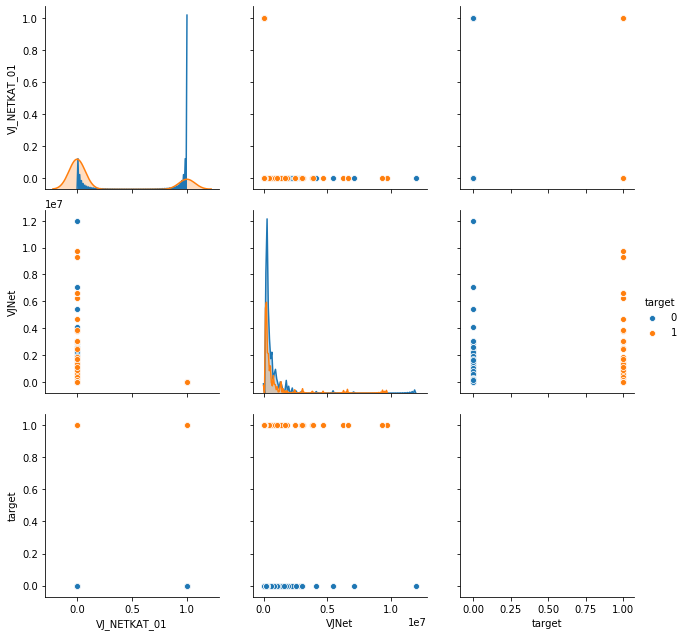

In [14]:
%%time
#pairplot
sns.pairplot(df_describe.loc[:,["VJ_NETKAT_01","VJNet","target"]], hue="target", height=3)
plt.savefig("pairplot.png")
#plt.show()

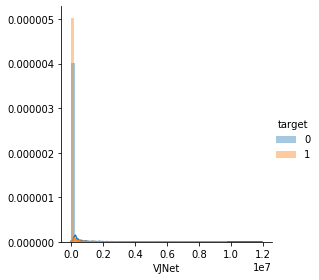

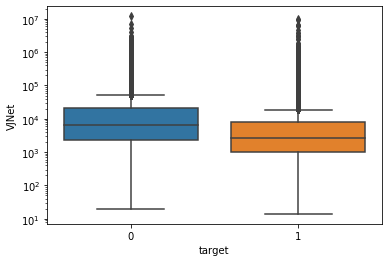

In [15]:
sns.FacetGrid(df_describe, hue="target", height=4).map(sns.distplot,"VJNet").add_legend()
plt.show()
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="target",y="VJNet", data=df_describe, ax=ax)
plt.show()

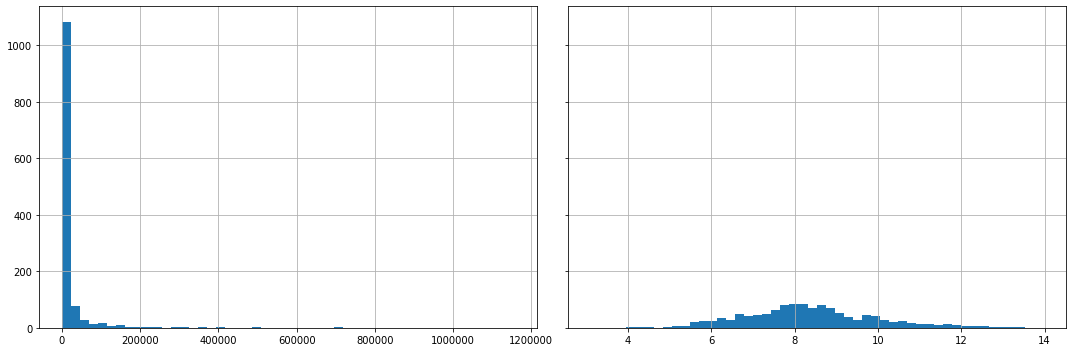

In [16]:
import matplotlib.mlab as mlab
from   matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

x = TDS.loc[TDS.AJ_29>0 ,"AJ_29"]
y = np.log(TDS.loc[TDS.AJ_29>0,"AJ_29"]+1)
n_bins=50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(15,5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[0].grid(True)
axs[1].hist(y, bins=n_bins)
axs[1].grid(True)

In [17]:
#TDS.loc[TDS.AJ_29>0,"AJ_29"]

## Dataset-Mapping to Zero/One

Prediktor festlegen: Aktuelle Woche basierend auf ``gv_AJAW_KW = 29``:

In [18]:
df_ft_binary = TDS.fillna(0).loc[:,feature_columns+["AJ_29"]]
for col in df_ft_binary.columns:
    df_ft_binary[col] = df_ft_binary[col].map(lambda x: int(bool(x)))

=> ``df_ft_binary``: Dataframe with features and target, all entries as binaries.

### Quick check

In [129]:
print("All occuring values in df_ft_binary are binary:",all(df_ft_binary.isin([0,1])))

All occuring values in df_ft_binary are binary: True


# Modelling

## Split: Training & Test

In [20]:
df_features = df_ft_binary.loc[:,feature_columns].to_numpy()
df_target   = df_ft_binary.loc[:, "AJ_29"].to_numpy()

In [21]:
#df_features    = TDS.fillna(0).loc[:,feature_columns].to_numpy()
#df_target      = TDS.fillna(0).loc[:,"AJ_29"].to_numpy()

print("Data type:")
print("df_features:", type(df_features))
print("df_target:", type(df_target))
print("\nShape:")
print("df_features:", df_features.shape)
print("df_target:", df_target.shape)
print("\nColumn Names:")
print("Features:\n", feature_columns)
print("Target:", "AJ_29") # <= NEEDS TO BE ADJUSTED!

Data type:
df_features: <class 'numpy.ndarray'>
df_target: <class 'numpy.ndarray'>

Shape:
df_features: (39215, 349)
df_target: (39215,)

Column Names:
Features:
 ['B105', 'B110', 'B115', 'B116', 'B120', 'B125', 'B130', 'B135', 'B140', 'B145', 'B150', 'B155', 'B160', 'B165', 'B170', 'B185', 'B195', 'B225', 'B230', 'B240', 'B241', 'B290', 'B295', 'B325', 'B330', 'B332', 'B334', 'B339', 'B349', 'B350', 'B351', 'B352', 'B353', 'B354', 'B356', 'B357', 'B366', 'B367', 'B371', 'B390', 'B400', 'B401', 'B405', 'B410', 'B420', 'B425', 'B435', 'B436', 'B445', 'B446', 'B447', 'B448', 'B455', 'B460', 'B464', 'B465', 'B466', 'B468', 'B469', 'B470', 'B475', 'B503', 'B504', 'B508', 'B509', 'B535', 'B555', 'B556', 'B575', 'B610', 'B695', 'B705', 'B720', 'B765', 'B780', 'B795', 'B800', 'B901', 'B950', 'B960', 'B970', 'B980', 'B990', 'VJNet', 'VJ_01', 'VJ_03', 'VJ_05', 'VJ_07', 'VJ_09', 'VJ_11', 'VJ_13', 'VJ_15', 'VJ_17', 'VJ_19', 'VJ_21', 'VJ_23', 'VJ_25', 'VJ_27', 'VJ_29', 'VJ_31', 'VJ_33', 'VJ_35', '

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)


In [23]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shape:
X_train: (29411, 349)
y_train: (29411,)
X_test: (9804, 349)
y_test: (9804,)


In [24]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))

y_train:
0
0    28473
1      938
Name: 0, dtype: int64
DescribeResult(nobs=29411, minmax=(0, 1), mean=0.03189282921355955, variance=0.030876726494310818, skewness=5.328034736308029, kurtosis=26.387954151304978)

y_test:
0
0    9475
1     329
Name: 0, dtype: int64
DescribeResult(nobs=9804, minmax=(0, 1), mean=0.03355773153814769, variance=0.03243491852738443, skewness=5.180165542954156, kurtosis=24.834115052409544)


<div class="alert alert-block alert-info">
<b>Remark:</b> Dataset is massively imbalanced! Only roughly 3% of the Training dataset is 1. This means if I predict all customers to have a Zero, I will be in 97% of the cases correct (on the training set). In order to achieve more reliable scoring models, the training dataset (X_train, y_train) has to be balanced.
</div>

### Balance Training Dataset

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [44]:
# pip install imblearn
#from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [132]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

pd.Series(y_train_balanced).value_counts()

y_train_balanced:
0
0    28473
1    28473
Name: 0, dtype: int64
DescribeResult(nobs=56946, minmax=(0, 1), mean=0.5, variance=0.25000439020107124, skewness=0.0, kurtosis=-2.0)


1    28473
0    28473
dtype: int64

## Model Training

###  Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

C is the Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

1. logreg:   $C = 1$
2. logreg01: $C = 0.1$
3. logreg00001: $C = 0.0001$
4. logreg100: $C = 100$

In [110]:
def create_logreg(C=[1]):
    """Create different models for varying C parameter. Put everything into a dictionary."""
    logreg_dict = {}
    for x in C:
        logreg_dict[x] = LogisticRegression(n_jobs=-1,
                                    solver="sag",
                                    C=x, # to be adjusted
                                    max_iter=1000000
                                   ).fit(X_train_balanced, y_train_balanced)
    return logreg_dict

In [111]:
logreg_dict = create_logreg([1,0.0001,0.01,0.1,100])

In [49]:
logreg_dict

{1: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0001: LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 0.01: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False

In [112]:
logreg_scores = pd.DataFrame([
    [x, logreg_dict[x].score(X_train_balanced, y_train_balanced),
        logreg_dict[x].score(X_test, y_test)] for x in logreg_dict.keys()], columns=["LogReg C", "Training set score","Test Set score"])

In [51]:
logreg_scores

,LogReg C,Training set score,Test Set score
0,1.0000,0.834510,0.757344
1,0.0001,0.706582,0.583231
2,0.0100,0.795842,0.695532
3,0.1000,0.823552,0.741228
4,100.0000,0.837460,0.758160


In [53]:
%%time
logreg = LogisticRegression(n_jobs=-1,
                            max_iter=100000,
                            solver="sag",
                            C=1000 # to be adjusted
                           ).fit(X_train_balanced, y_train_balanced)

#logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.842
Test set score: 0.763
Wall time: 4min 1s


In [54]:
%%time
# %% Train data: LogReg with C = 0.01
logreg001 = LogisticRegression(n_jobs=-1,
                               max_iter=100000,
                               solver="sag", # L2 regularisation
                               C=0.01 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Training set score: 0.796
Test set score: 0.696
Wall time: 2.34 s


In [55]:
%%time
logreg00001 = LogisticRegression(n_jobs=-1,
                                 max_iter=100000,
                               solver="sag",
                               C=0.0001 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg00001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg00001.score(X_test, y_test)))

Training set score: 0.707
Test set score: 0.583
Wall time: 2.02 s


In [56]:
%%time
logreg100 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=100 #adjustable
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg100.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set score: 0.842
Test set score: 0.763
Wall time: 3min 31s


#### Plot coefficients

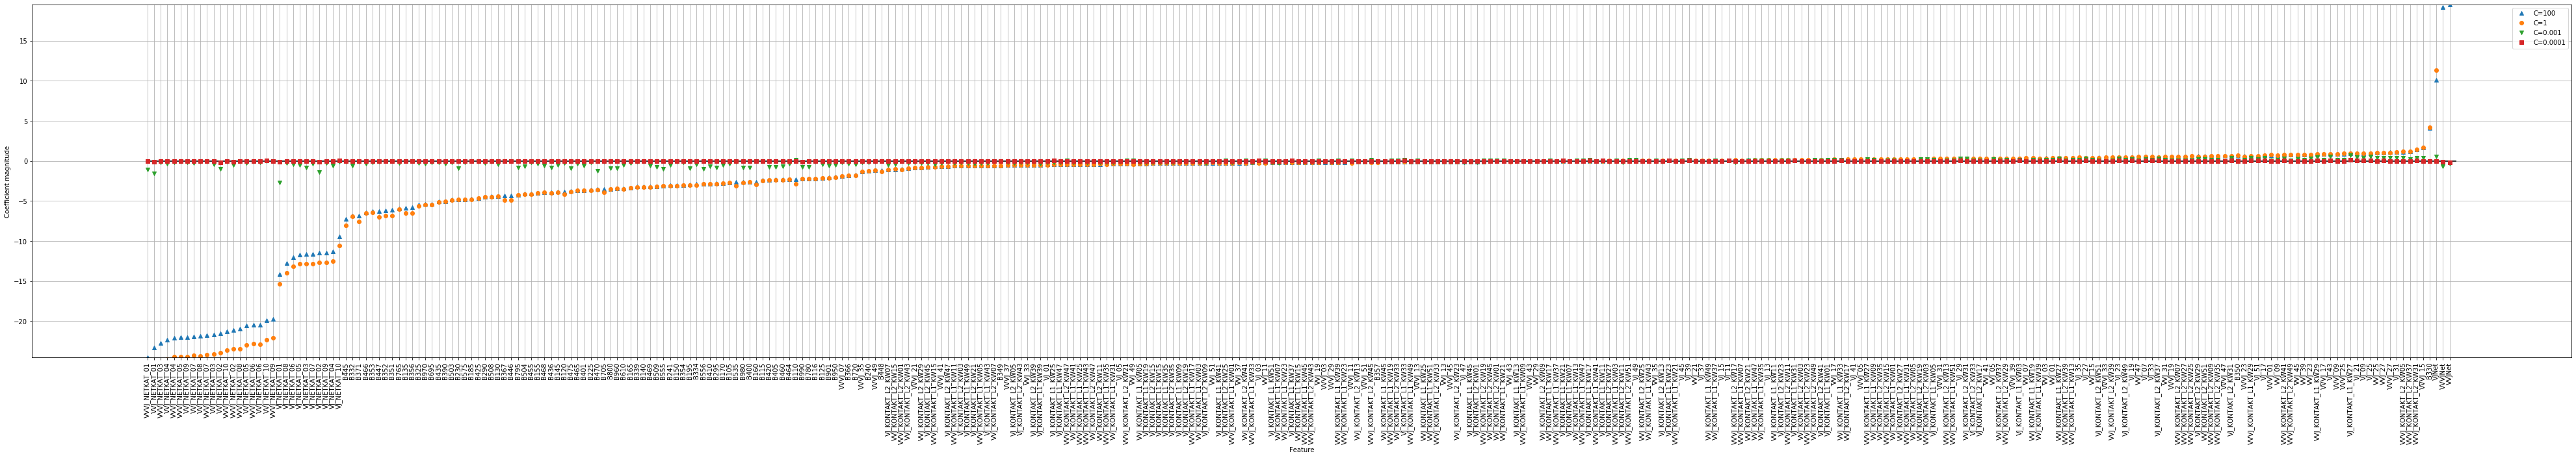

In [57]:
temp = np.asarray([x for [x] in logreg100.coef_.T]).argsort()
ranks= np.empty_like(temp)
ranks[temp] = np.arange(len(temp))

sorted_logreg100       = [0 for x in range(len(temp))]
sorted_logreg          = [0 for x in range(len(temp))]
sorted_logreg001       = [0 for x in range(len(temp))]
sorted_logreg00001     = [0 for x in range(len(temp))]
sorted_feature_columns = [0 for x in range(len(temp))]
for i in range(len(temp)):
    sorted_logreg100[ranks[i]]       = logreg100.coef_.T[i]
    sorted_logreg[ranks[i]]          = logreg.coef_.T[i]
    sorted_logreg001[ranks[i]]       = logreg001.coef_.T[i]
    sorted_logreg00001[ranks[i]]     = logreg00001.coef_.T[i]
    sorted_feature_columns[ranks[i]] = feature_columns[i]
    
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(sorted_logreg100 , '^', label="C=100")
plt.plot(sorted_logreg,    'o', label="C=1")
plt.plot(sorted_logreg001, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), sorted_feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg100.coef_.T), max(logreg100.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

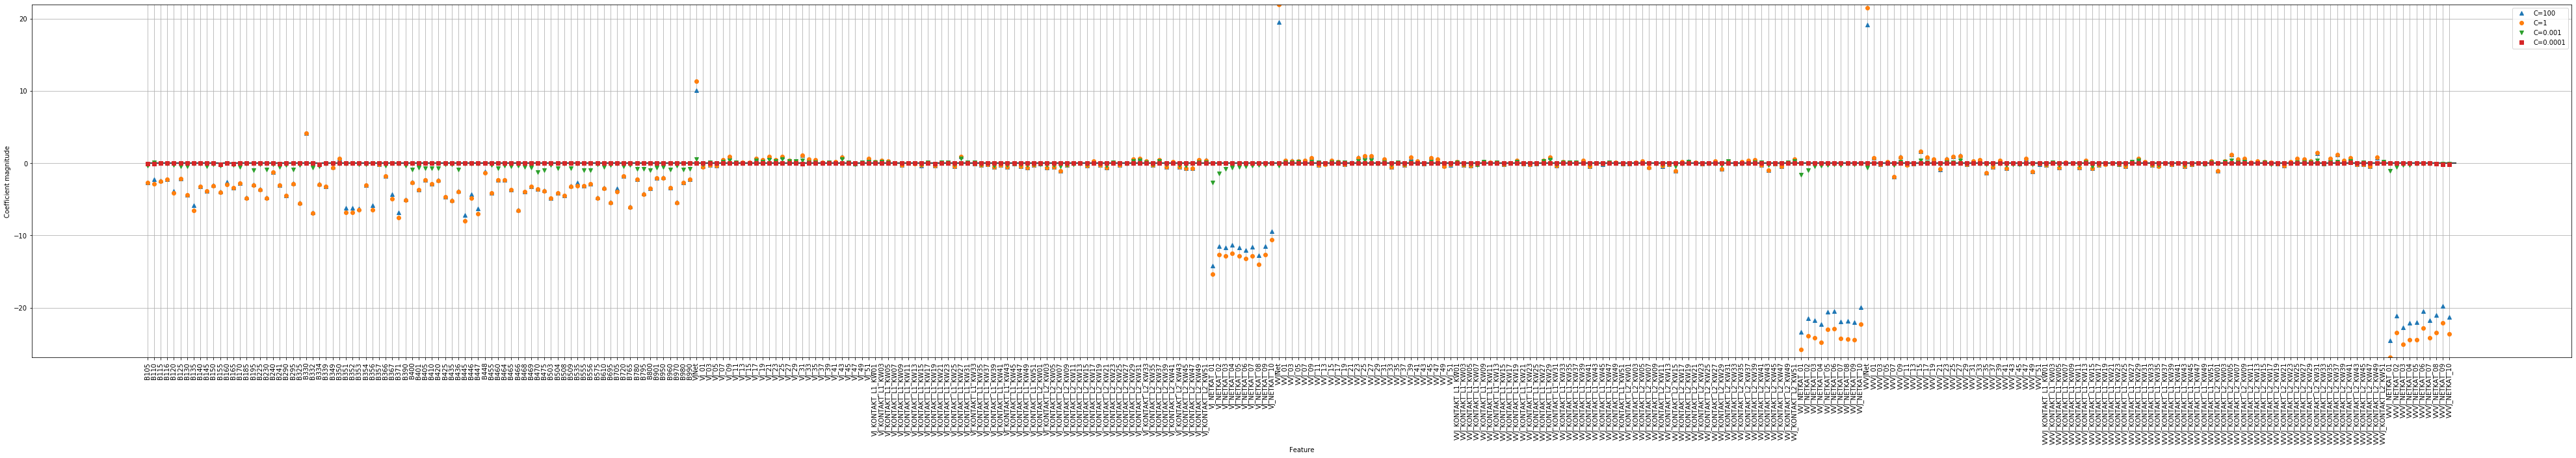

In [58]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T,    'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg.coef_.T), max(logreg.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Lasso

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
%%time
lasso = Lasso().fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

In [ ]:
%%time
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

In [ ]:
%%time

lasso00000001 = Lasso(alpha=0.0000001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso00000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso00000001.score(X_test,      y_test)))
print("Number of features used:", np.sum(lasso00000001.coef_ != 0))

In [ ]:
%%time
lasso000001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso000001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso000001.coef_ != 0))

=> ALL SUPERMASSIVE CRAP

### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
%%time

forest = RandomForestClassifier(n_estimators=10000,
                                max_depth=15,
                                random_state=42,
                                n_jobs=-1)
forest.fit(X_train_balanced, y_train_balanced)

# %% Validate Accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,y_train_balanced)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test,     y_test)))

Accuracy on training set: 0.831
Accuracy on test set: 0.699
Wall time: 7min 18s


In [61]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

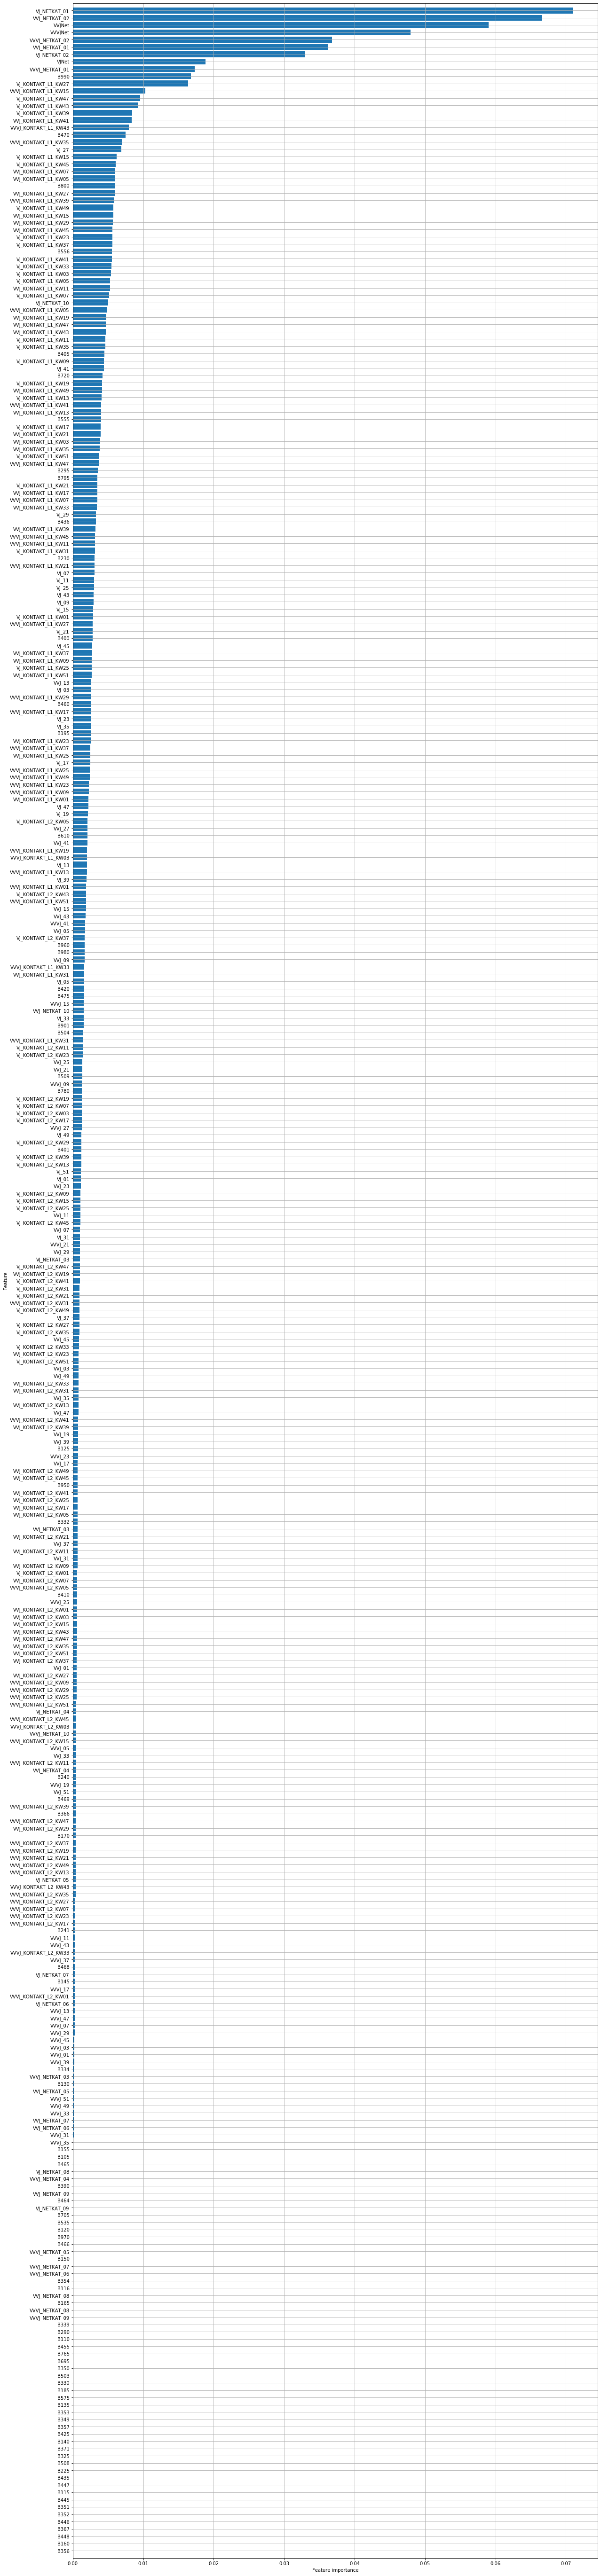

In [62]:
plot_feature_importances(forest,feature_columns)
#plot_feature_importances(forest_selected,feature_columns_selected)

# Automated Feature selection: SelectPercentile

In [63]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

1. ``f_classif `` ANOVA assumes normal distribution. (nope)
2. ``mutual_info_classif`` Mutual information for a discrete target.
3. ``chi2`` Chis-squared starts of non-negative features for classification tasks.
4. ``f_regression`` F-value between label/feature for regression tasks.
5. ``mutual_info_regression`` Mutual information for a continuous target.
6. ``SelectKBest`` Select features based on the k highest scores
7. ``SelectFpr`` Select features based on a FPR test.
8. ``SelectFdr`` Select features based on an estimated false discovery rate
9. ``SelectFwe`` Select features based on family-wise error rate.
10. ``GenericUnivariateSelect`` Univariate feature selector with configurable mode.

In [133]:
%%time
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=50)
select.fit(X_train_balanced, y_train_balanced)
# transform training set
X_train_selected = select.transform(X_train_balanced) # not needed. we have the mask (boolean array).

print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train_balanced.shape: (56946, 349)
X_train_selected.shape: (56946, 174)
Wall time: 2min 43s


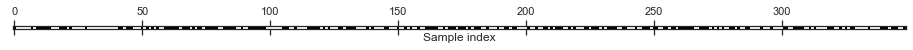

In [113]:
mask = select.get_support()
#print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [116]:
from itertools import compress
feature_columns_selected = list(compress(feature_columns,mask))

print("Selected features:\n",feature_columns_selected)
#print(feature_columns)

Selected features:
 ['B105', 'B135', 'B145', 'B150', 'B155', 'B160', 'B165', 'B170', 'B230', 'B240', 'B241', 'B295', 'B349', 'B401', 'B405', 'B420', 'B425', 'B435', 'B447', 'B455', 'B464', 'B466', 'B470', 'B475', 'B503', 'B504', 'B508', 'B509', 'B555', 'B556', 'B575', 'B695', 'B720', 'B765', 'B795', 'B800', 'B901', 'B950', 'B960', 'B990', 'VJNet', 'VJ_01', 'VJ_03', 'VJ_05', 'VJ_11', 'VJ_17', 'VJ_19', 'VJ_21', 'VJ_23', 'VJ_25', 'VJ_27', 'VJ_29', 'VJ_43', 'VJ_45', 'VJ_47', 'VJ_KONTAKT_L1_KW01', 'VJ_KONTAKT_L1_KW11', 'VJ_KONTAKT_L1_KW13', 'VJ_KONTAKT_L1_KW15', 'VJ_KONTAKT_L1_KW17', 'VJ_KONTAKT_L1_KW19', 'VJ_KONTAKT_L1_KW23', 'VJ_KONTAKT_L1_KW27', 'VJ_KONTAKT_L1_KW37', 'VJ_KONTAKT_L1_KW39', 'VJ_KONTAKT_L1_KW43', 'VJ_KONTAKT_L1_KW45', 'VJ_KONTAKT_L1_KW47', 'VJ_KONTAKT_L1_KW49', 'VJ_KONTAKT_L2_KW07', 'VJ_KONTAKT_L2_KW11', 'VJ_KONTAKT_L2_KW21', 'VJ_KONTAKT_L2_KW23', 'VJ_KONTAKT_L2_KW31', 'VJ_KONTAKT_L2_KW37', 'VJ_KONTAKT_L2_KW41', 'VJ_KONTAKT_L2_KW47', 'VJ_NETKAT_01', 'VJ_NETKAT_02', 'VJ_NETK

In [67]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (56946, 349)
X_train_selected.shape: (56946, 174)
X_train_balanced[:,mask].shape: (56946, 174)


In [68]:
%%time
logreg_selected = LogisticRegression(n_jobs=-1,
                            solver="sag",
                            C=1 # to be adjusted
                           ).fit(X_train_balanced[:,mask], # We select only those we need
                                 y_train_balanced)

forest_selected = RandomForestClassifier(n_estimators=10000,
                                max_depth=35,
                                random_state=42,
                                n_jobs=-1)

forest_selected.fit(X_train_balanced[:,mask],
           y_train_balanced)

Wall time: 6min 8s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [69]:
# %% Validate Accuracy
print("Random Forest, newly selected features:")
print("Accuracy on training set: {:.3f}".format(forest_selected.score(X_train_balanced[:,mask],
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest_selected.score(X_test[:,mask],
                                                         y_test)))

print("\nLogististic Regression C=1, newly selected features:")
print("Training set score: {:.3f}".format(logreg_selected.score(X_train_balanced[:,mask], # Obviously only applicable to the subselect
                                                                y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg_selected.score(X_test[:,mask], # Obviously only applicable to the subselect
                                                            y_test)))

print("\nLogististic Regression C=1, all features:")
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced,y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

print("\nRandom Forest, all features:")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest.score(X_test,
                                                         y_test)))
print("\n")

Random Forest, newly selected features:
Accuracy on training set: 0.894
Accuracy on test set: 0.785

Logististic Regression C=1, newly selected features:
Training set score: 0.787
Test set score: 0.703

Logististic Regression C=1, all features:
Training set score: 0.842
Test set score: 0.763

Random Forest, all features:
Accuracy on training set: 0.831
Accuracy on test set: 0.699




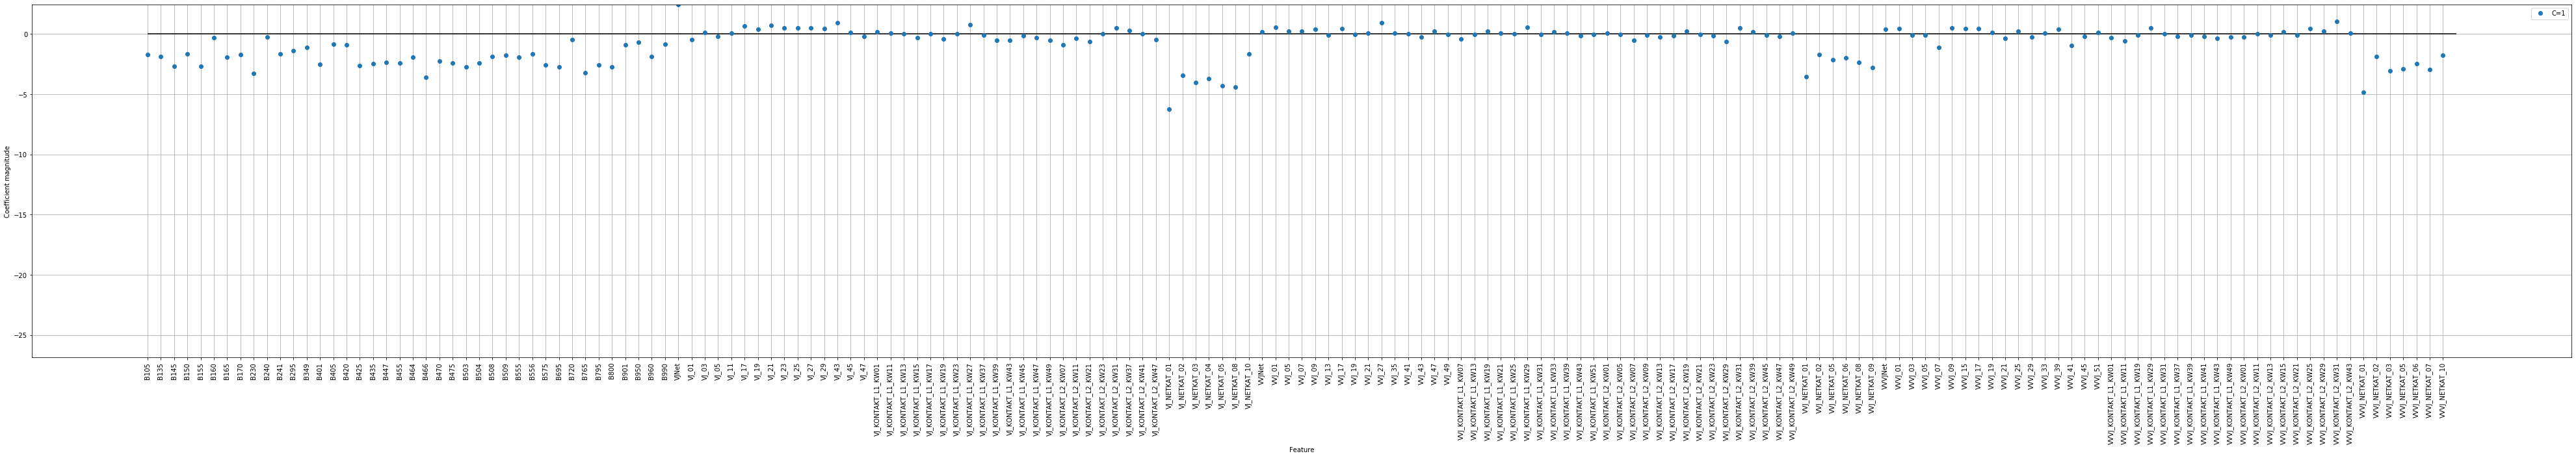

In [70]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_selected.coef_.T,    'o', label="C=1")
plt.xticks(range(len(feature_columns_selected)), feature_columns_selected, rotation=90)
plt.hlines(0, 0, len(feature_columns_selected))
plt.ylim(min(logreg.coef_.T), max(logreg_selected.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

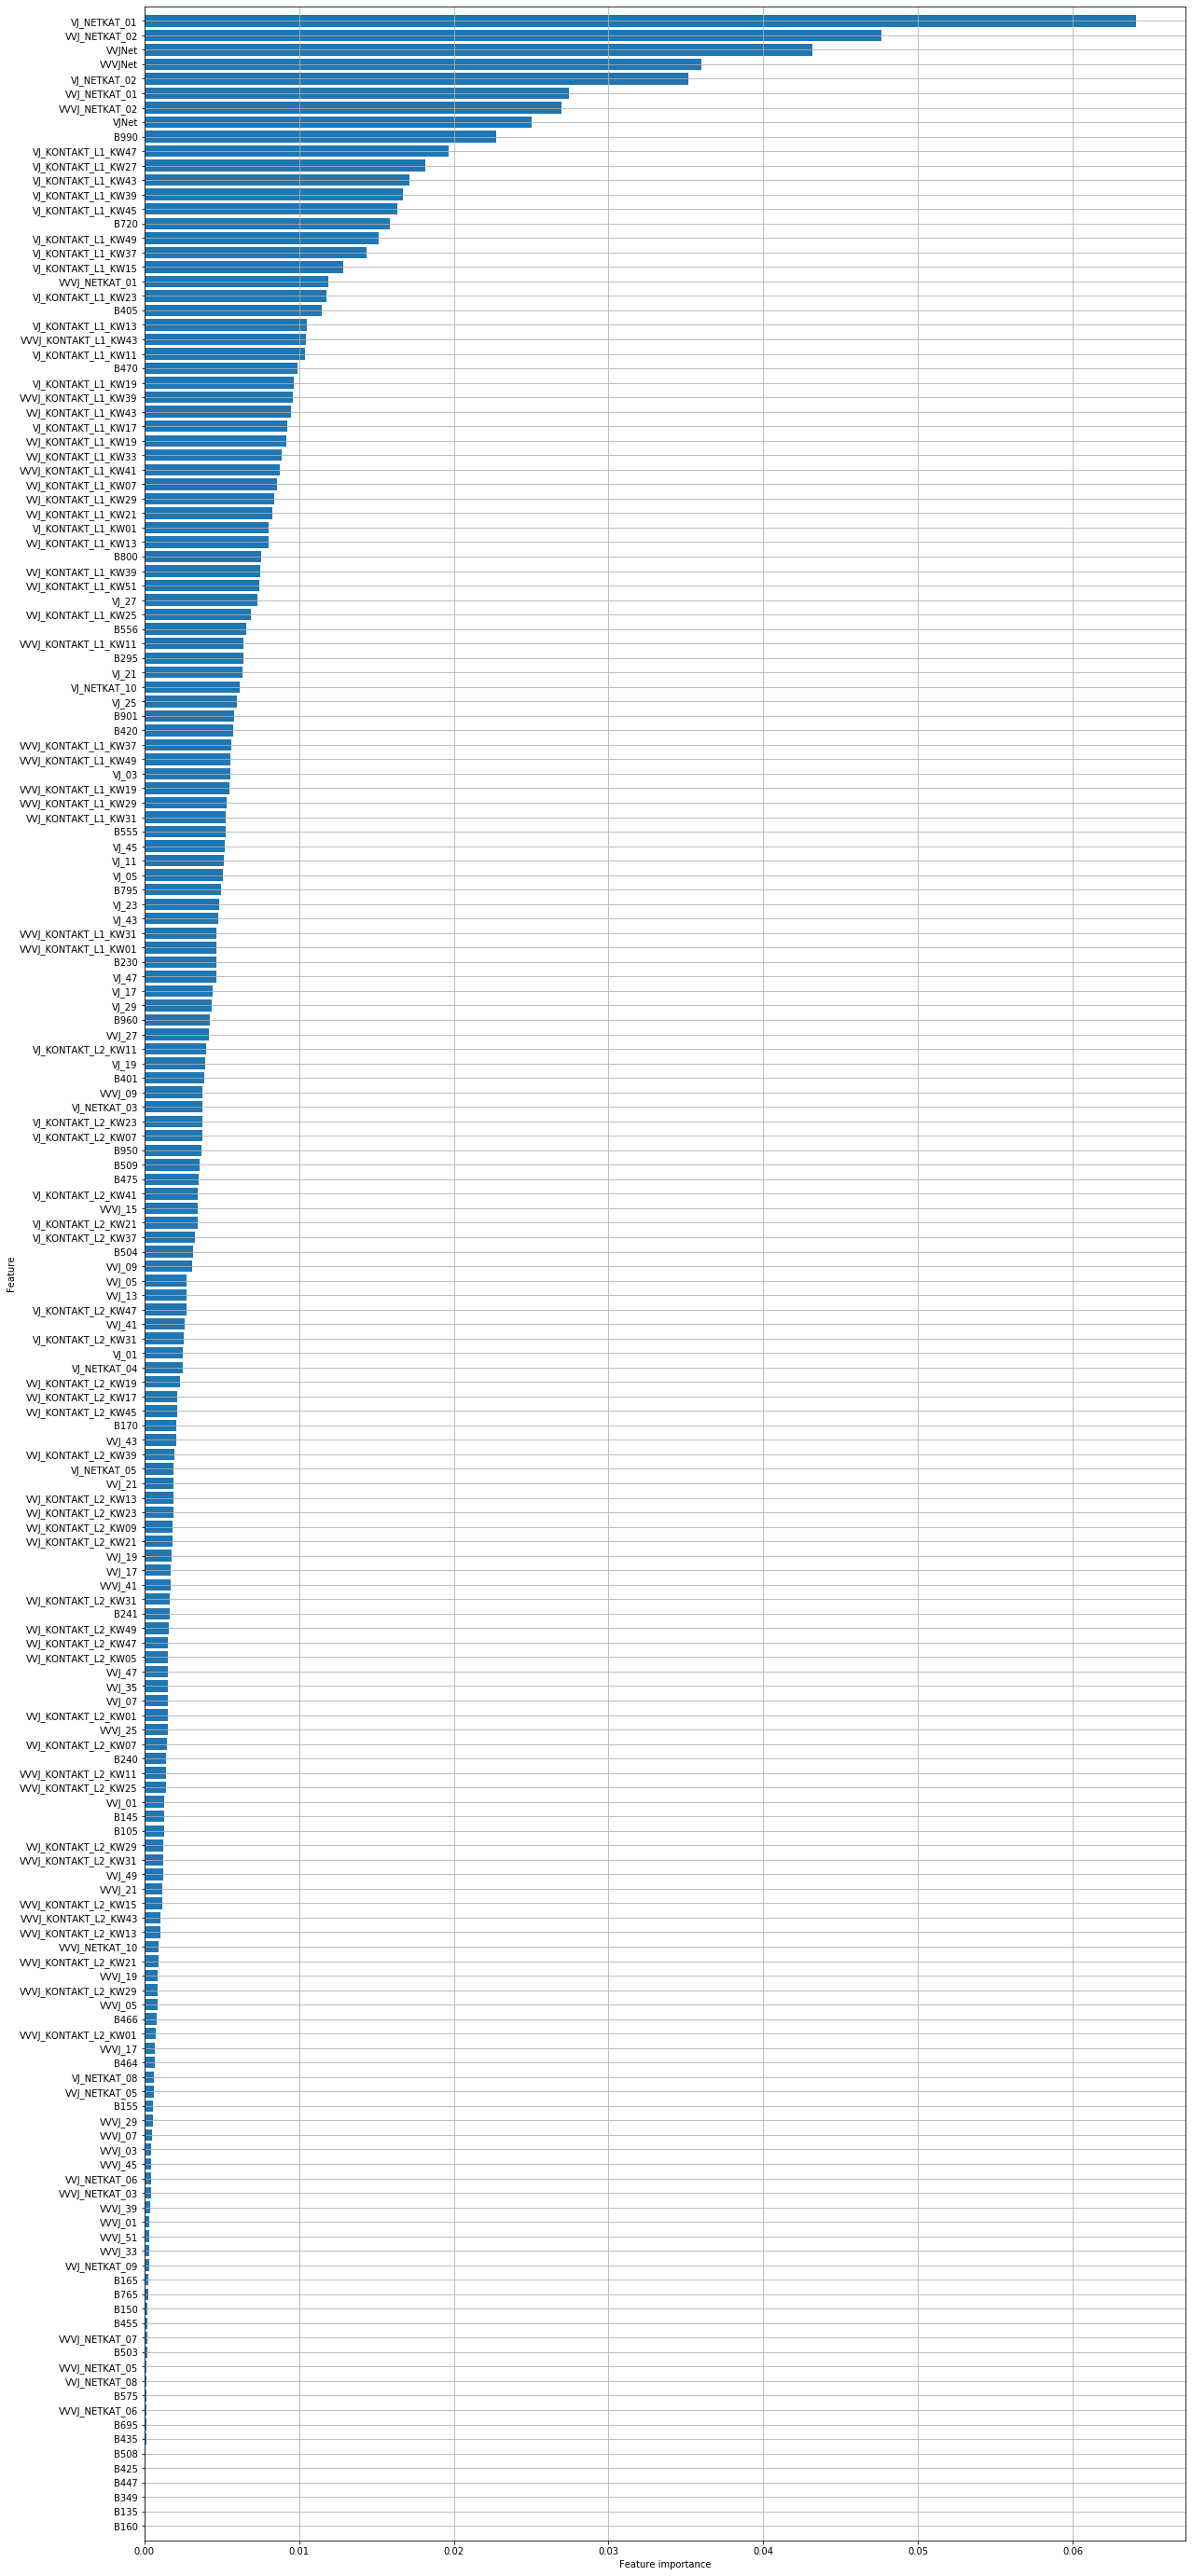

In [71]:
plot_feature_importances(forest_selected,
                         feature_columns_selected,
                         figsize=(20,50))

# Model Validatian 

## Confusion Matrix

In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
%%time
#logreg = LogisticRegression(C=1, solver='lbfgs').fit(X_train_binary, y_train_binary)
pred_logreg          = logreg.predict(X_test)
pred_logreg_selected = logreg_selected.predict(X_test[:,mask])
pred_forest          = forest.predict(X_test)
pred_forest_selected = forest_selected.predict(X_test[:,mask])

Wall time: 1min 11s


In [77]:
%%time
confusion_logreg             = confusion_matrix(y_test, pred_logreg)
df_confusion_logreg          = pd.DataFrame(confusion_logreg, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_logreg_selected    = confusion_matrix(y_test, pred_logreg_selected)
df_confusion_logreg_selected = pd.DataFrame(confusion_logreg_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest             = confusion_matrix(y_test, pred_forest)
df_confusion_forest          = pd.DataFrame(confusion_forest, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest_selected    = confusion_matrix(y_test, pred_forest_selected)
df_confusion_forest_selected = pd.DataFrame(confusion_forest_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

print("Test set balance:")
print(sorted(Counter(y_test).items()),"\n")

print("Confusion Matrices:")

print("Logistic Regression C=1:")
display(df_confusion_logreg)

print("Logistic Regression C=1, newly selected features:")
display(df_confusion_logreg_selected)

print("Random Forest:")
display(df_confusion_forest)

print("Random Forest, newly selected features:")
display(df_confusion_forest_selected)

Test set balance:
[(0, 9475), (1, 329)] 

Confusion Matrices:
Logistic Regression C=1:


,Pred 0,Pred 1
Fact 0,7375,2100
Fact 1,228,101


Logistic Regression C=1, newly selected features:


,Pred 0,Pred 1
Fact 0,6763,2712
Fact 1,200,129


Random Forest:


,Pred 0,Pred 1
Fact 0,6741,2734
Fact 1,219,110


Random Forest, newly selected features:


,Pred 0,Pred 1
Fact 0,7615,1860
Fact 1,244,85


Wall time: 172 ms


In [78]:
#import mglearn
#mglearn.plots.plot_binary_confusion_matrix()

1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


In [79]:
from sklearn.metrics import classification_report
print("Logistic Regression C=1:")
print(classification_report(y_test,
                            pred_logreg,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Logistic Regression C=1, newly selected features:")
print(classification_report(y_test,
                            pred_logreg_selected,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Random Forest:")
print(classification_report(y_test,
                            pred_forest,
                            target_names=["not booking = 0", "booking = 1"]))

print("\n")
print("Random Forest, new selected:")
print(classification_report(y_test,
                            pred_forest_selected,
                            target_names=["not booking = 0", "booking = 1"]))

Logistic Regression C=1:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.78      0.86      9475
    booking = 1       0.05      0.31      0.08       329

       accuracy                           0.76      9804
      macro avg       0.51      0.54      0.47      9804
   weighted avg       0.94      0.76      0.84      9804



Logistic Regression C=1, newly selected features:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.71      0.82      9475
    booking = 1       0.05      0.39      0.08       329

       accuracy                           0.70      9804
      macro avg       0.51      0.55      0.45      9804
   weighted avg       0.94      0.70      0.80      9804



Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.71      0.82      9475
    booking = 1       0.04      0.33      0.07       329

       accuracy                           0

Lower the Threshold:

In [80]:
def threshold_test(number):
    y_pred_lower_threshold = logreg.decision_function(X_test) > number
    print(classification_report(y_test, y_pred_lower_threshold))

In [81]:
threshold_test(0.1)

              precision    recall  f1-score   support

           0       0.97      0.80      0.87      9475
           1       0.05      0.30      0.08       329

    accuracy                           0.78      9804
   macro avg       0.51      0.55      0.48      9804
weighted avg       0.94      0.78      0.85      9804



In [82]:
def prob_threshold(number):
    y_pred_prob_threshold = np.asarray([y for [x,y] in logreg100.predict_proba(X_test)]) > number
    print(classification_report(y_test, y_pred_prob_threshold))

In [86]:
for x in np.around(np.arange(0,1,0.1),decimals=1):
    print("Threshold =",x,":")
    print(prob_threshold(x),"\n")


Threshold = 0.0 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9475
           1       0.03      1.00      0.06       329

    accuracy                           0.03      9804
   macro avg       0.02      0.50      0.03      9804
weighted avg       0.00      0.03      0.00      9804

None 

Threshold = 0.1 :


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      0.45      0.62      9475
           1       0.04      0.58      0.07       329

    accuracy                           0.46      9804
   macro avg       0.50      0.51      0.34      9804
weighted avg       0.94      0.46      0.60      9804

None 

Threshold = 0.2 :
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      9475
           1       0.04      0.47      0.07       329

    accuracy                           0.56      9804
   macro avg       0.50      0.52      0.39      9804
weighted avg       0.94      0.56      0.69      9804

None 

Threshold = 0.3 :
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      9475
           1       0.04      0.40      0.07       329

    accuracy                           0.64      9804
   macro avg       0.50      0.52      0.42      9804
weighted avg       0.94 

In [109]:
import seaborn as sns

def boxplot_histogram(x, bins=None, figsize=(15,10)):
    """Creates two plots stacked underneath each other. Upper plot: Boxplot. Lower plot: Histogram. Input is any array."""
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=figsize)

    sns.boxplot(x, notch=True,ax=ax_box)
    sns.distplot(x, ax=ax_hist,bins=bins)
    ax_hist.grid(True)
    ax_hist.set_title('Historgram')
    ax_hist.set_ylabel('Percentage')
    ax_hist.set_xlabel('Value Range')

    ax_box.set(yticks=[])
    ax_box.set_title('Boxplot')
    ax_box.grid(True)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.show()
    

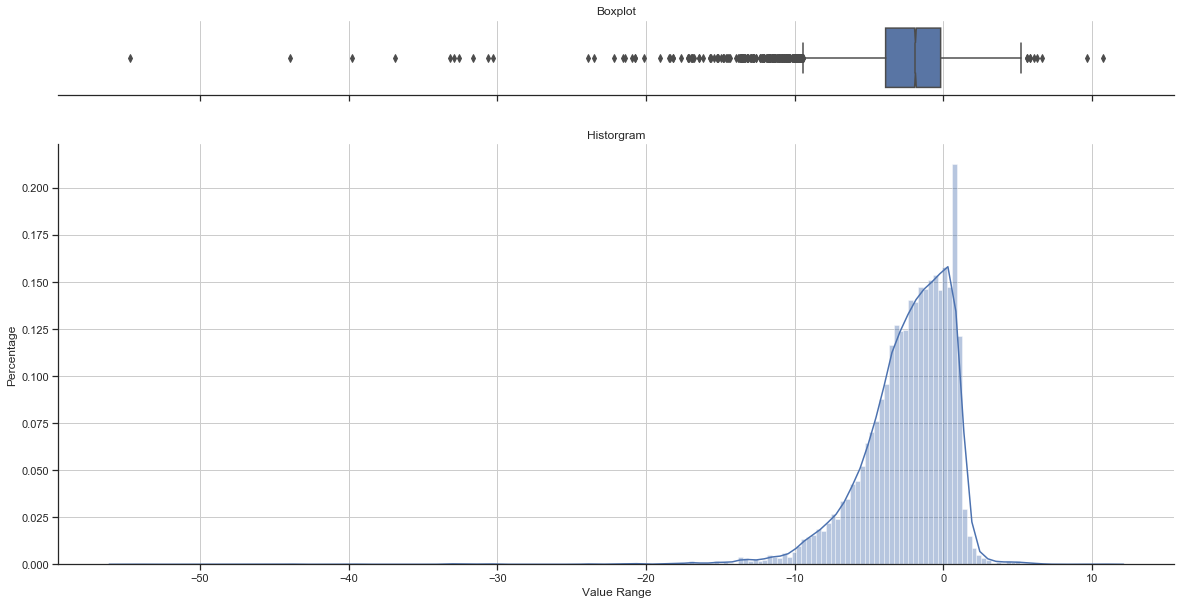

In [100]:
boxplot_histogram(logreg.decision_function(X_test), 
                  #np.random.normal(loc=10, scale=5, size=10000), # gaussian distributed array, mean = 10, standard deviation = 5, length = 100000
                  bins=200,
                  figsize=(20,10))

In [99]:
threshold_test(-100)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9475
           1       0.03      1.00      0.06       329

    accuracy                           0.03      9804
   macro avg       0.02      0.50      0.03      9804
weighted avg       0.00      0.03      0.00      9804



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Precision-Recall curve

In [101]:
%%time
from sklearn.metrics import precision_recall_curve

def prec_rec_curve(X_test,y_test):
    global precision_logreg, recall_logreg, thresholds_logreg, precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected, precision_forest, recall_forest, thresholds_forest, precision_forest_selected, recall_forest_selected, thresholds_forest_selected
    
    precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(
        y_test, 
        logreg.decision_function(X_test))

    #
    precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected = precision_recall_curve(
        y_test, 
        logreg_selected.decision_function(X_test[:,mask]))

    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest, recall_forest, thresholds_forest = precision_recall_curve(
        y_test,
        forest.predict_proba(X_test)[:, 1])

    precision_forest_selected, recall_forest_selected, thresholds_forest_selected = precision_recall_curve(
        y_test,
        forest_selected.predict_proba(X_test[:,mask])[:, 1])


Wall time: 0 ns


In [102]:
%%time
#prec_rec_curve(X_test,y_test)
prec_rec_curve(X_train,y_train)

Wall time: 1min 25s


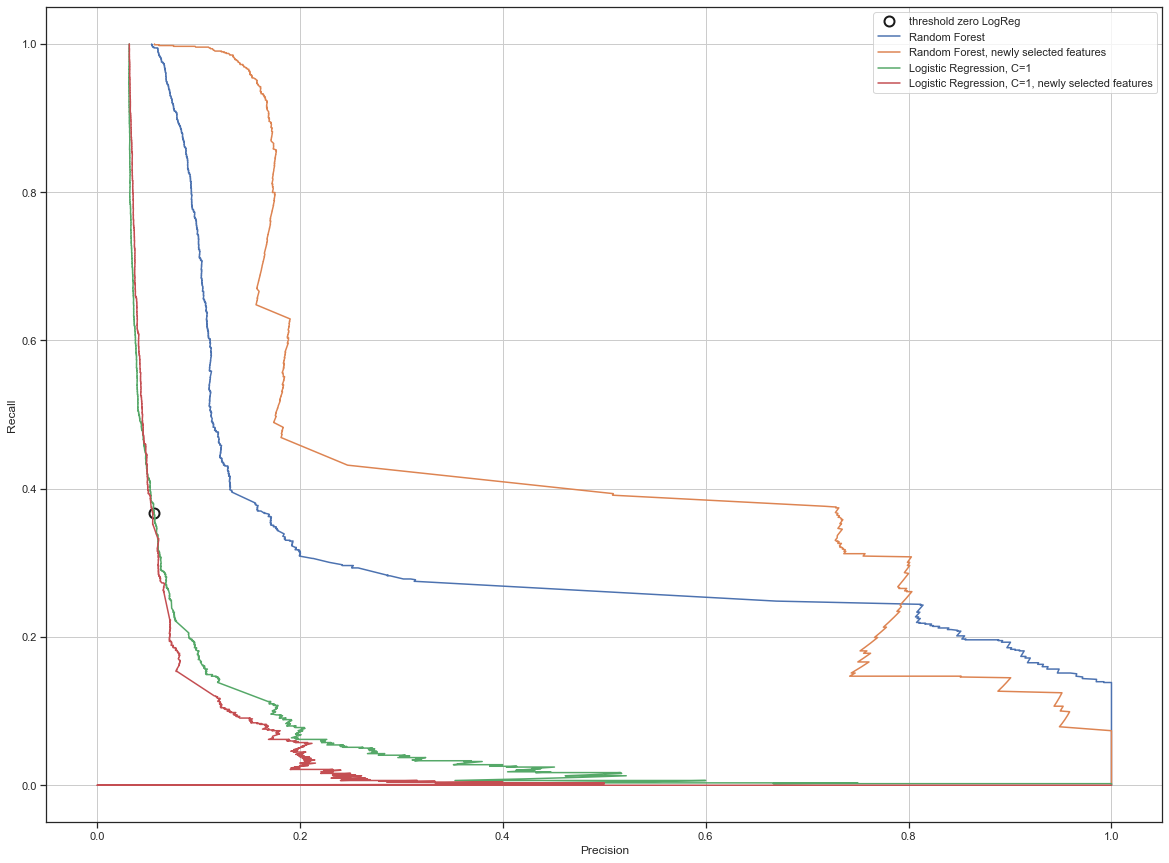

In [103]:
plt.figure(figsize=(20,15))
plt.grid()

close_zero = np.argmin(np.abs(thresholds_logreg))
plt.plot(precision_logreg[close_zero],
         recall_logreg[close_zero],
         'o',
         markersize=10,
         label="threshold zero LogReg",
         fillstyle="none",
         c='k',
         mew=2)

plt.plot(precision_forest, recall_forest, label="Random Forest")
plt.plot(precision_forest_selected, recall_forest_selected, label="Random Forest, newly selected features")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression, C=1")
plt.plot(precision_logreg_selected, recall_logreg_selected, label="Logistic Regression, C=1, newly selected features")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

plt.show()

<div class="alert alert-block alert-info">
<b>Remark:</b> This plot looks horrible. HORRIBLE!!!
</div>

In [104]:
%%time
from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_forest = average_precision_score(y_test,
                                               forest.predict_proba(X_test)[:, 1])

avg_precision_forest_selected = average_precision_score(y_test,
                                               forest_selected.predict_proba(X_test[:,mask])[:, 1])

avg_precision_logreg = average_precision_score(y_test,
                                               logreg.decision_function(X_test))

avg_precision_logreg_selected = average_precision_score(y_test,
                                               logreg_selected.decision_function(X_test[:,mask]))

print("Average Precision of Random Forest: {:.3f}".format(avg_precision_forest))
print("Average Precision of Random Forest, newly selected features: {:.3f}".format(avg_precision_forest_selected))
print("Average Precision of Logistic Regression C=1: {:.3f}".format(avg_precision_logreg))
print("Average Precision of Logistic Regression C=1, newly selected features: {:.3f}".format(avg_precision_logreg_selected))

Average Precision of Random Forest: 0.045
Average Precision of Random Forest, newly selected features: 0.048
Average Precision of Logistic Regression C=1: 0.051
Average Precision of Logistic Regression C=1, newly selected features: 0.057
Wall time: 1min 14s


## Receiver operating characteristics (ROC) and AUC

1. $FPR = \frac{FP}{FP + TN}$ 
2. $TPR = Recall$

In [105]:
%%time
from sklearn.metrics import roc_curve

fpr_logreg,          tpr_logreg,          thresholds_logreg      = roc_curve(y_test, logreg.decision_function(X_test))
fpr_logreg00001,     tpr_logreg00001,     thresholds_logreg00001 = roc_curve(y_test, logreg00001.decision_function(X_test))
fpr_logreg001,       tpr_logreg001,       thresholds_logreg001       = roc_curve(y_test, logreg001.decision_function(X_test))
fpr_logreg100,       tpr_logreg100,       thresholds_logreg100       = roc_curve(y_test, logreg100.decision_function(X_test))
fpr_logreg_selected, tpr_logreg_selected, thresholds_logreg_selected = roc_curve(y_test, logreg_selected.decision_function(X_test[:,mask]))
fpr_forest,          tpr_forest,          thresholds_forest      = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])
fpr_forest_selected, tpr_forest_selected, thresholds_forest_selected = roc_curve(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

Wall time: 1min 13s


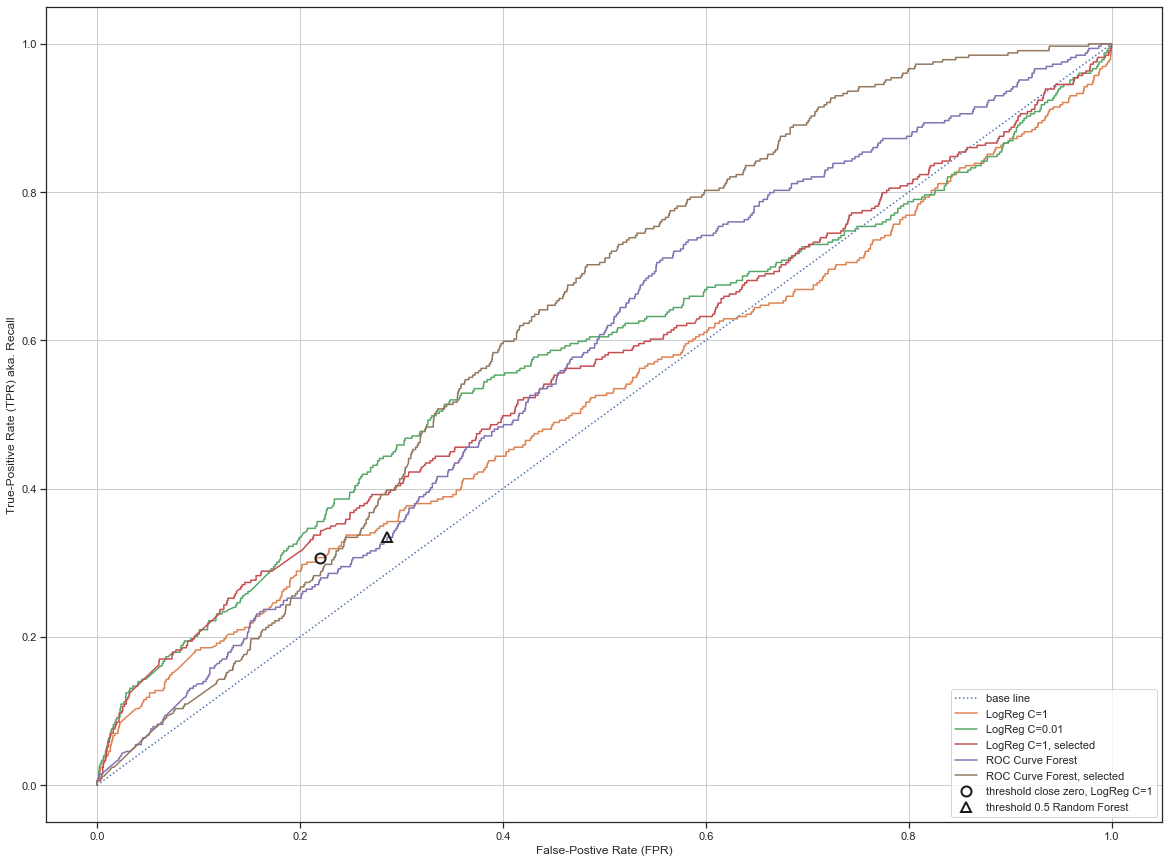

Wall time: 279 ms


In [106]:
%%time
plt.figure(figsize=(20,15))
plt.grid()

plt.plot(fpr_logreg,fpr_logreg, linestyle='dotted', label="base line")

plt.plot(fpr_logreg,      tpr_logreg,      label="LogReg C=1")
#plt.plot(fpr_logreg00001, tpr_logreg00001, label="LogReg C=0.0001")  # bad!
plt.plot(fpr_logreg001,   tpr_logreg001,   label="LogReg C=0.01")
#plt.plot(fpr_logreg100,   tpr_logreg100,   label="LogReg C=100.0")
plt.plot(fpr_logreg_selected, tpr_logreg_selected,  label="LogReg C=1, selected")
plt.plot(fpr_forest,      tpr_forest,      label="ROC Curve Forest")
plt.plot(fpr_forest_selected,tpr_forest_selected,      label="ROC Curve Forest, selected")


plt.xlabel("False-Postive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR) aka. Recall")

# find threshold closest to zero
close_zero_index = np.argmin(np.abs(thresholds_logreg))
plt.plot(fpr_logreg[close_zero_index], tpr_logreg[close_zero_index],
         'o',
         markersize=10,
         label="threshold close zero, LogReg C=1",
         fillstyle="none",
         c='k',
         mew=2)

close_default_index_forest = np.argmin(np.abs(thresholds_forest - 0.5))
plt.plot(fpr_forest[close_default_index_forest], tpr_forest[close_default_index_forest],
         '^',
         markersize=10,
         label="threshold 0.5 Random Forest",
         fillstyle="none",
         c='k',
         mew=2)

plt.legend(loc=4)
plt.show()

In [107]:
%%time
from sklearn.metrics import roc_auc_score
forest_auc = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
forest_selected_auc = roc_auc_score(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

logreg001_auc       = roc_auc_score(y_test, logreg001.decision_function(X_test))
logreg_auc          = roc_auc_score(y_test, logreg.decision_function(X_test))
logreg00001_auc     = roc_auc_score(y_test, logreg00001.decision_function(X_test))
logreg100_auc       = roc_auc_score(y_test, logreg100.decision_function(X_test))
logreg_selected_auc = roc_auc_score(y_test, logreg_selected.decision_function(X_test[:,mask]))

Wall time: 1min 13s


In [108]:
print("AUC for Random Forest:           {:.3f}".format(forest_auc))
print("AUC for Random Forest, selected: {:.3f}".format(forest_selected_auc))
print("AUC for LogReg C=0.001:          {:.3f}".format(logreg001_auc))
print("AUC for LogReg C=0.0001:         {:.3f}".format(logreg00001_auc))
print("AUC for LogReg C=1, selected:    {:.3f}".format(logreg_selected_auc))
print("AUC for LogReg C=1:              {:.3f}".format(logreg_auc))
print("AUC for LogReg C=100:            {:.3f}".format(logreg100_auc))

AUC for Random Forest:           0.575
AUC for Random Forest, selected: 0.627
AUC for LogReg C=0.001:          0.573
AUC for LogReg C=0.0001:         0.566
AUC for LogReg C=1, selected:    0.561
AUC for LogReg C=1:              0.522
AUC for LogReg C=100:            0.523


# Cross-Validation in Scikit-Learn

1. https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch05.html#model-evaluation-and-improvement
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html


In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg,
                         np.concatenate([X_train_balanced,X_test]),
                         np.concatenate([y_train_balanced,y_test]), 
                         cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.81746686 0.84929968 0.85378277 0.84448273 0.83092366]


In [73]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.84


In [74]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg,
                     np.concatenate([X_train_balanced,X_test]),
                     np.concatenate([y_train_balanced,y_test]),
                     cv=5,
                     return_train_score=True)
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,285.901725,0.031211,0.817467,0.852900
1,218.323795,0.015652,0.849300,0.839828
2,220.823135,0.031245,0.853783,0.837959
3,214.839310,0.031245,0.844483,0.839741
4,239.974186,0.031218,0.830924,0.844591


Mean times and scores:
 fit_time       235.972430
score_time       0.028114
test_score       0.839191
train_score      0.843004
dtype: float64
